In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
import inspect

In [4]:
pattern1 = '../results/CURRENT/stats/2023-04-23*.log'
pattern2 = '../results/CURRENT/stats/2023-04-24*.log'
files = glob.glob(pattern1) + glob.glob(pattern2)

column_names = ['ID','Name','CPU_Percentage','Memory_Usage','Memory_Percentage','Net_IO','Block_IO']

# Read all files and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, names=column_names, header=0) for file in files]
df = pd.concat(dataframes, ignore_index=True)


In [5]:
def conv(s):
    # Extract all numbers (including decimals) as strings along with their units
    number_strings_with_units = re.findall(r'(\d+(?:\.\d+)?)([GMKk]?i?B)', s)

    numbers = []
    for num_str, unit in number_strings_with_units:
        num = float(num_str)
        if unit in ['GiB', 'GB']:
            num *= 10**6
        elif unit in ['MiB', 'MB']:
            num *= 10**3
        # elif unit in ['KiB', 'kB', 'KB']:
        #     num *= 10**(-3)
        numbers.append(num)

    return numbers

In [6]:
# Remove "%" sign from columns with percentages
df = df.drop('ID', axis=1)
df['Name'] = df['Name'].apply(str.strip)
df['CPU_Percentage'] = df['CPU_Percentage'].str.replace('%', '').astype(float)
df['Memory_Percentage'] = df['Memory_Percentage'].str.replace('%', '').astype(float)
df['Memory_Usage'] = df['Memory_Usage'].apply(conv)
df['Net_IO'] = df['Net_IO'].apply(conv)
df['Block_IO'] = df['Block_IO'].apply(conv)
df[['Memory_in_use', 'Available_memory']] = pd.DataFrame(df['Memory_Usage'].tolist(), index=df.index)
df[['Net_IO_in', 'Net_IO_out']] = pd.DataFrame(df['Net_IO'].tolist(), index=df.index)
df[['Block_IO_in', 'Block_IO_out']] = pd.DataFrame(df['Block_IO'].tolist(), index=df.index)

In [7]:
df.head()

Name  CPU_Percentage            Memory_Usage   
0   bfl-ml_client_3           56.81  [787500.0, 31290000.0]  \
1   bfl-ml_client_7           71.47  [679700.0, 31290000.0]   
2   bfl-ml_client_2           63.18  [666300.0, 31290000.0]   
3   bfl-ml_client_8           79.44  [662600.0, 31290000.0]   
4  bfl-ml_client_10           63.98  [709000.0, 31290000.0]   

   Memory_Percentage              Net_IO         Block_IO  Memory_in_use   
0               2.46  [29000.0, 24800.0]    [8.19, 102.0]       787500.0  \
1               2.12  [29900.0, 31500.0]  [9190.0, 102.0]       679700.0   
2               2.08  [33900.0, 33600.0]     [4.1, 102.0]       666300.0   
3               2.07  [27800.0, 26100.0]    [8.19, 102.0]       662600.0   
4               2.21  [41300.0, 38900.0]  [10700.0, 98.3]       709000.0   

   Available_memory  Net_IO_in  Net_IO_out  Block_IO_in  Block_IO_out  
0        31290000.0    29000.0     24800.0         8.19         102.0  
1        31290000.0    29900.0     31500.0      9190.00         102.0  
2        31290000.0    33900.0     33600.0         4.10         102.0  
3        31290000.0    27800.0     26100.0         8.19         102.0  
4        31290000.0    41300.0     38900.0     10700.00          98.3

In [8]:
df_client1 = df.loc[df['Name'] == 'bfl-ml_client_1']
df_client1 = df_client1.drop('Name', axis=1)

In [9]:
df_client1.head()

CPU_Percentage            Memory_Usage  Memory_Percentage   
7            46.95  [636900.0, 31290000.0]               1.99  \
29           51.20  [648200.0, 31290000.0]               2.02   
51           73.84  [709300.0, 31290000.0]               2.21   
73           82.74  [658200.0, 31290000.0]               2.05   
95           66.37  [679500.0, 31290000.0]               2.12   

                Net_IO       Block_IO  Memory_in_use  Available_memory   
7   [23100.0, 20600.0]  [582.0, 98.3]       636900.0        31290000.0  \
29  [23200.0, 20600.0]  [582.0, 98.3]       648200.0        31290000.0   
51  [23200.0, 20600.0]  [582.0, 98.3]       709300.0        31290000.0   
73  [23200.0, 20600.0]  [582.0, 98.3]       658200.0        31290000.0   
95  [23300.0, 20600.0]  [582.0, 98.3]       679500.0        31290000.0   

    Net_IO_in  Net_IO_out  Block_IO_in  Block_IO_out  
7     23100.0     20600.0        582.0          98.3  
29    23200.0     20600.0        582.0          98.3  
51    23200.0     20600.0        582.0          98.3  
73    23200.0     20600.0        582.0          98.3  
95    23300.0     20600.0        582.0          98.3

In [10]:
def classify(input_string):
    if "client" in input_string:
        return "Trainer"
    elif "miner" in input_string:
        return "Miner"
    elif "server" in input_string:
        return "Aggregator"
    elif "rpc-endpoint" in input_string:
        return "RPC Endpoint"
    else:
        return "Unknown"

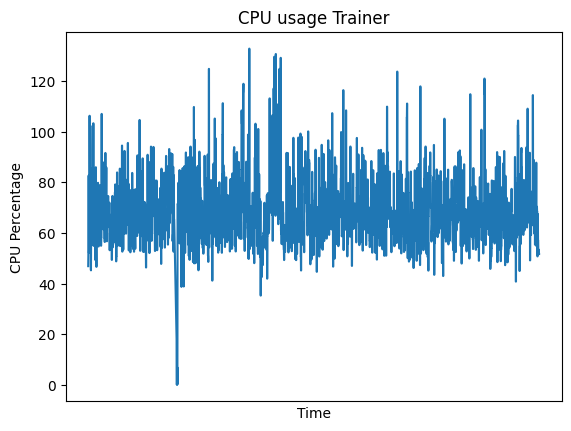

In [11]:
def do_cpu(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]
    plt.plot(df_1['CPU_Percentage'])
    plt.title('CPU usage {}'.format(classify(name)))
    plt.xlabel('Time')
    plt.ylabel('CPU Percentage')
    plt.gca().set_xticks([])
    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_cpu('bfl-ml_client_1', df)


/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

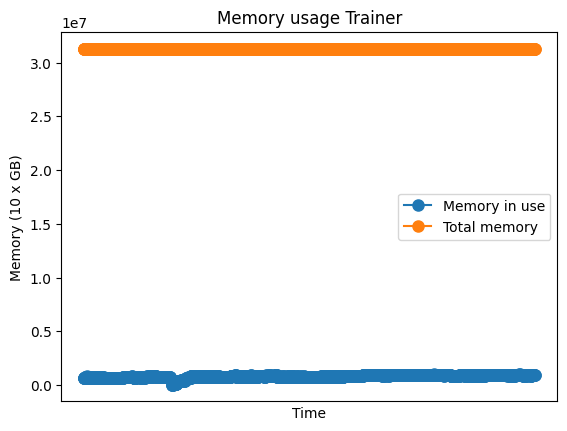

In [12]:

def do_mem(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]
    ax = df_1.plot( y=['Memory_in_use', 'Available_memory'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Memory (10 x GB)')
    ax.set_title('Memory usage {}'.format(classify(name)))

    plt.legend(['Memory in use', 'Total memory'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_mem('bfl-ml_client_1', df)

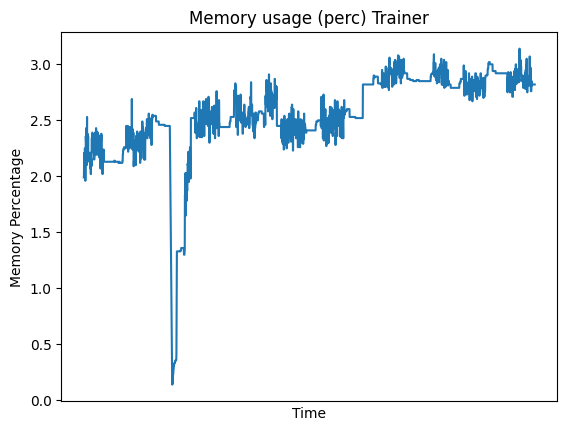

In [13]:
def do_mem_perc(name, df):
    plt.figure()
    plt.title('Memory usage (perc) {}'.format(classify(name)))
    df_1 = df.loc[df['Name'] == name]
    plt.plot(df_1['Memory_Percentage'])
    plt.xlabel('Time')
    plt.ylabel('Memory Percentage')
    plt.gca().set_xticks([])
    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_mem_perc('bfl-ml_client_1', df)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

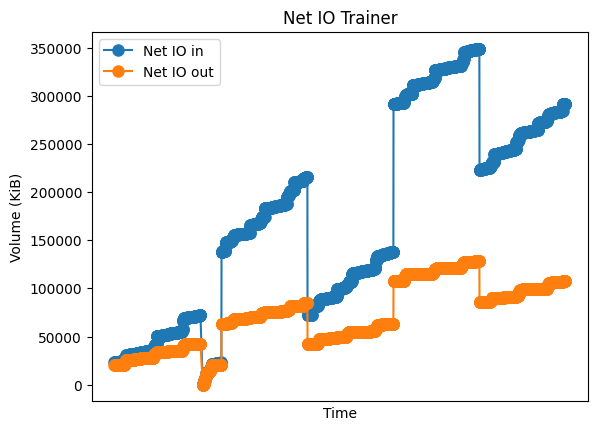

In [14]:
def do_io(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]

    ax = df_1.plot( y=['Net_IO_in', 'Net_IO_out'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Volume (KiB)')
    ax.set_title('Net IO {}'.format(classify(name)))

    plt.legend(['Net IO in', 'Net IO out'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_io('bfl-ml_client_1', df)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


<Figure size 640x480 with 0 Axes>

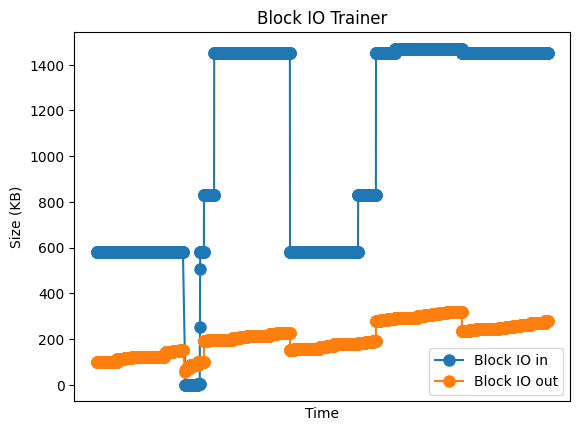

In [15]:
def do_block_io(name, df):
    plt.figure()
    df_1 = df.loc[df['Name'] == name]

    ax = df_1.plot( y=['Block_IO_in', 'Block_IO_out'], style='o-', marker='o', markersize=8)
    ax.set_ylabel('Size (KB)')
    ax.set_title('Block IO {}'.format(classify(name)))

    plt.legend(['Block IO in', 'Block IO out'])
    plt.xlabel('Time')
    plt.gca().set_xticks([])

    plt.savefig('{}_{}.png'.format(name, inspect.currentframe().f_code.co_name), dpi=300)

do_block_io('bfl-ml_client_1', df)

In [16]:
names = df['Name'].unique()
names.sort()

In [17]:
names

array(['affectionate_agnesi', 'bfl-ml_client_1', 'bfl-ml_client_10',
       'bfl-ml_client_2', 'bfl-ml_client_3', 'bfl-ml_client_4',
       'bfl-ml_client_5', 'bfl-ml_client_6', 'bfl-ml_client_7',
       'bfl-ml_client_8', 'bfl-ml_client_9', 'bfl-ml_server_1',
       'bfl_geth-miner_1', 'bfl_geth-miner_10', 'bfl_geth-miner_2',
       'bfl_geth-miner_3', 'bfl_geth-miner_4', 'bfl_geth-miner_5',
       'bfl_geth-miner_6', 'bfl_geth-miner_7', 'bfl_geth-miner_8',
       'bfl_geth-miner_9', 'bfl_geth-rpc-endpoint_1', 'reverent_shirley',
       'stupefied_taussig'], dtype=object)

/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/andras/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:885: UserWarning: marker is redundantly defined by the 'marker' keywo

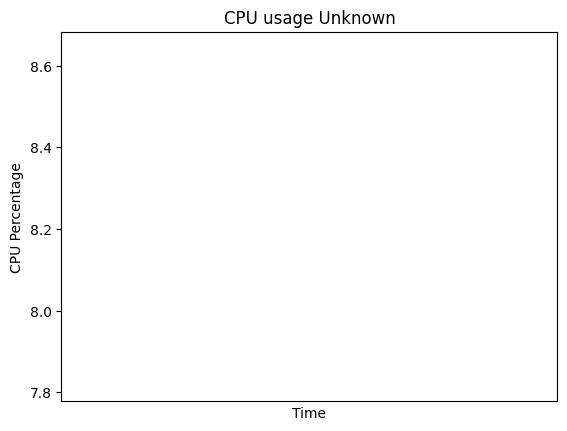

<Figure size 640x480 with 0 Axes>

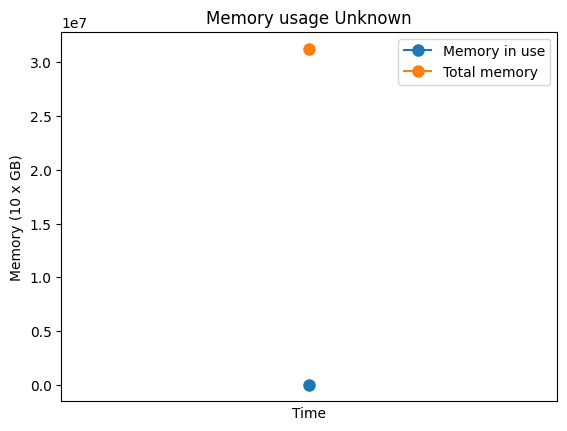

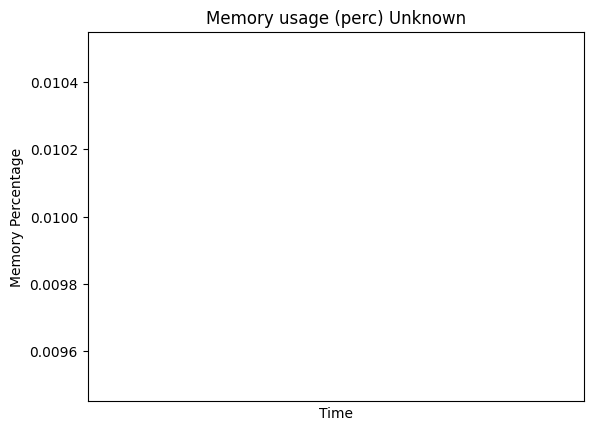

<Figure size 640x480 with 0 Axes>

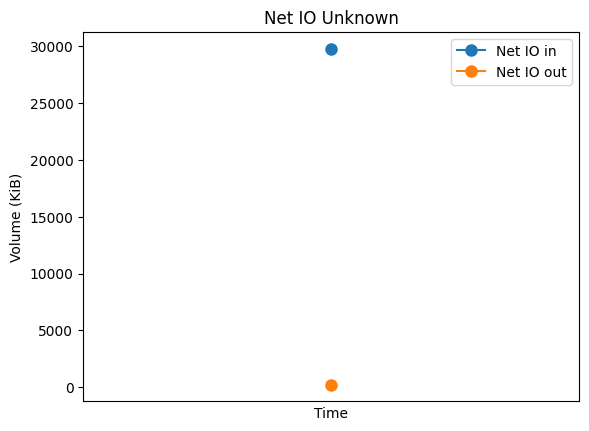

<Figure size 640x480 with 0 Axes>

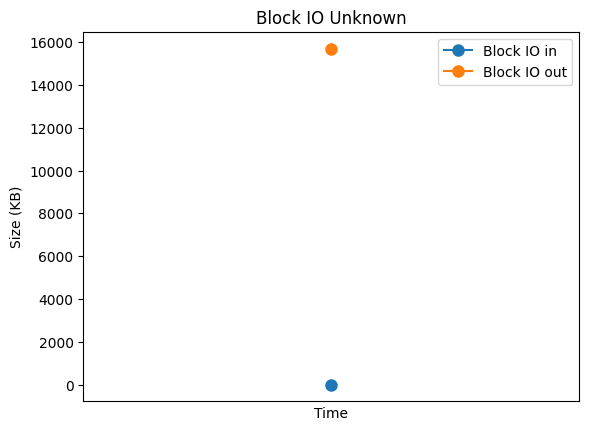

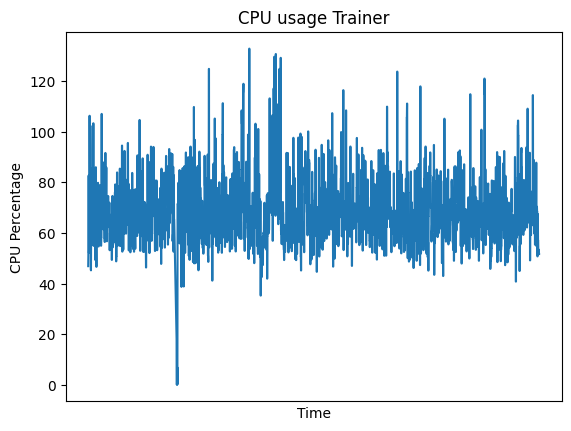

<Figure size 640x480 with 0 Axes>

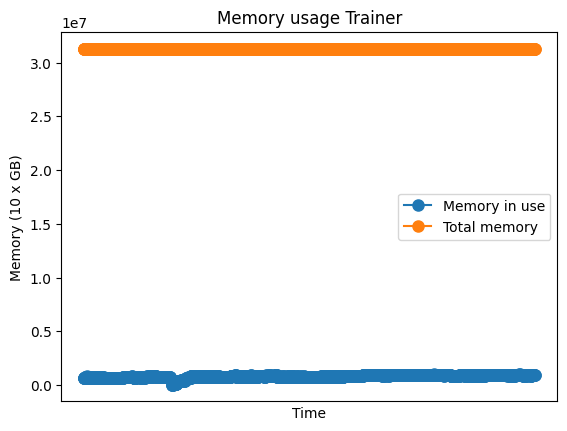

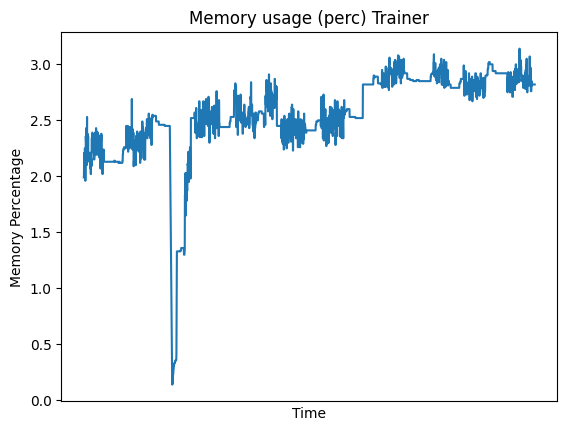

<Figure size 640x480 with 0 Axes>

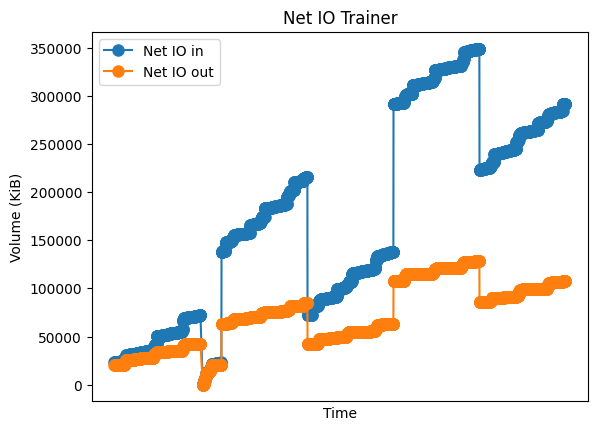

<Figure size 640x480 with 0 Axes>

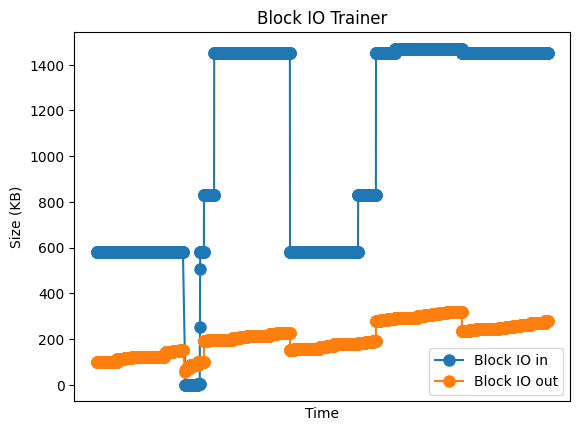

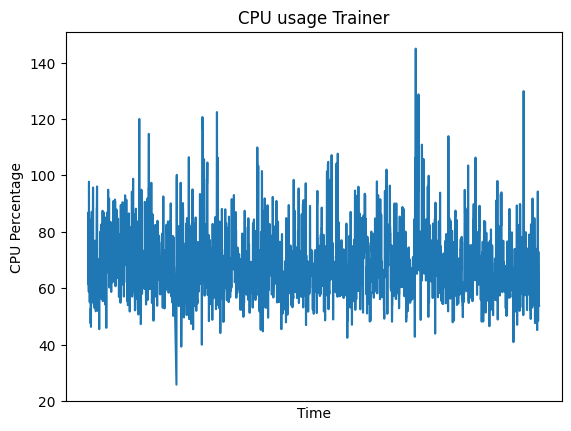

<Figure size 640x480 with 0 Axes>

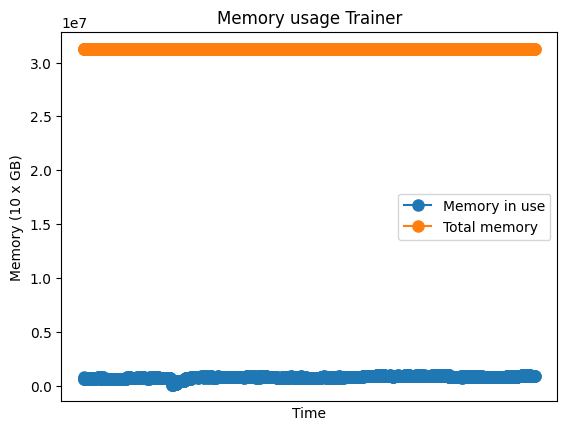

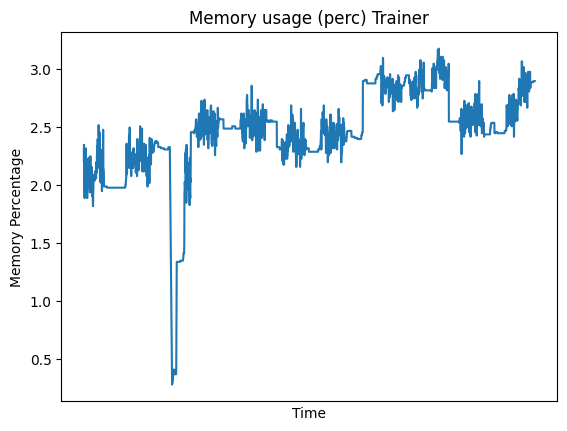

<Figure size 640x480 with 0 Axes>

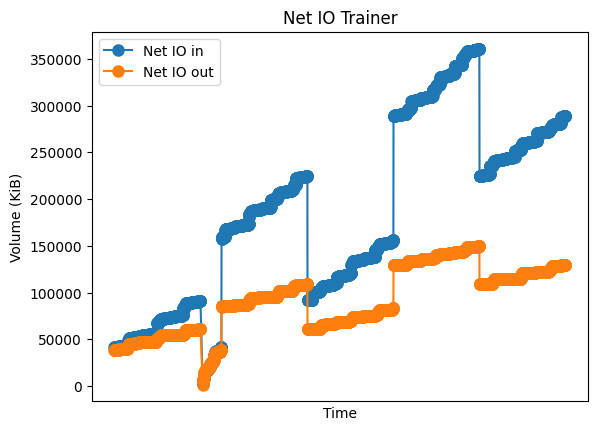

<Figure size 640x480 with 0 Axes>

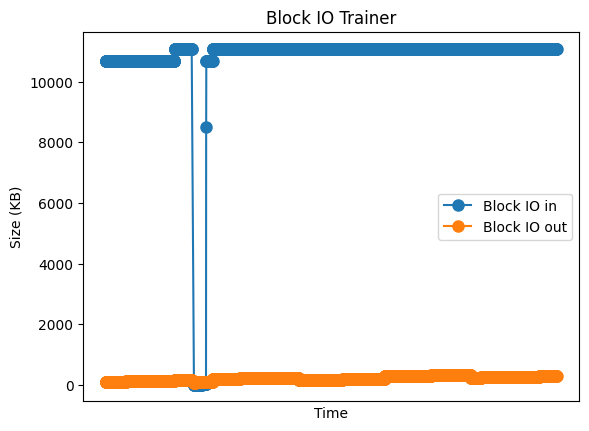

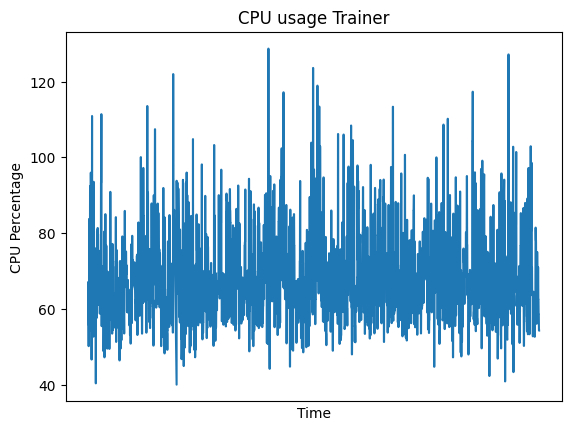

<Figure size 640x480 with 0 Axes>

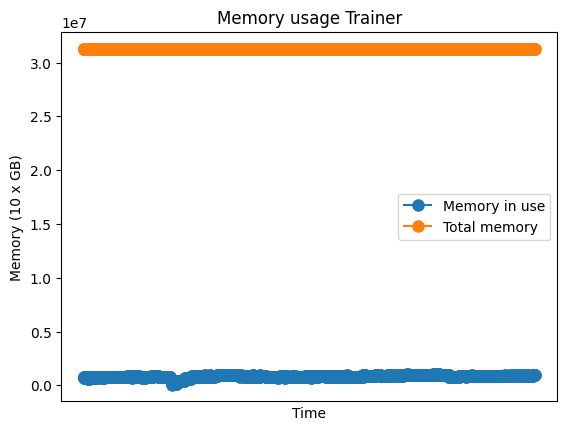

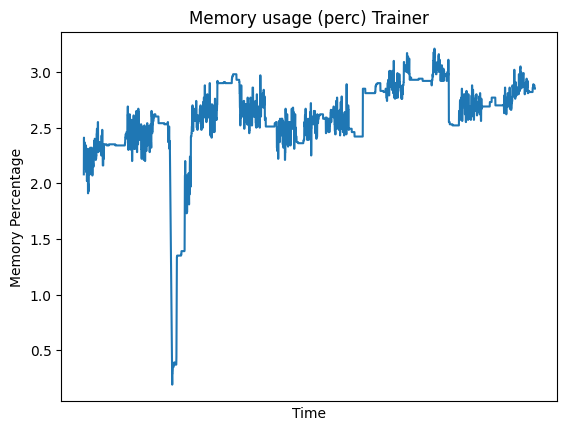

<Figure size 640x480 with 0 Axes>

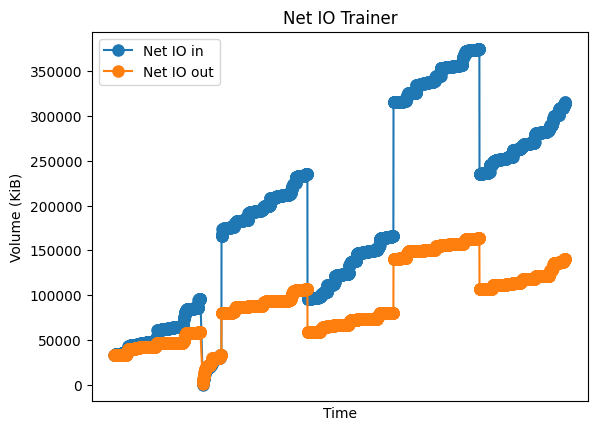

<Figure size 640x480 with 0 Axes>

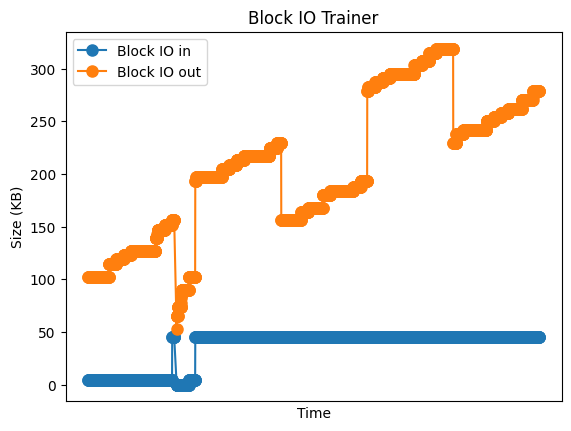

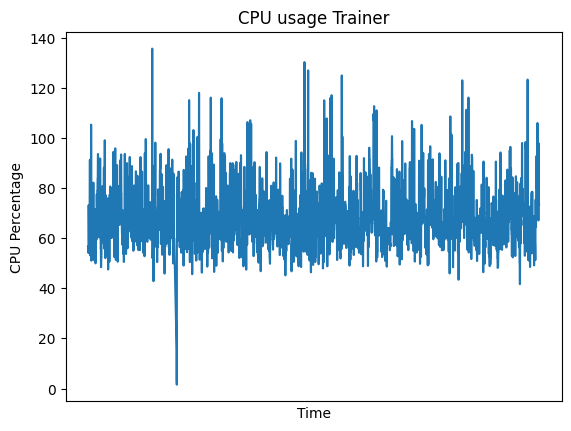

<Figure size 640x480 with 0 Axes>

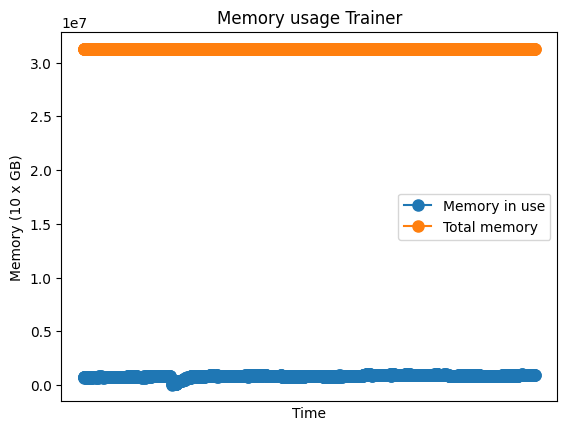

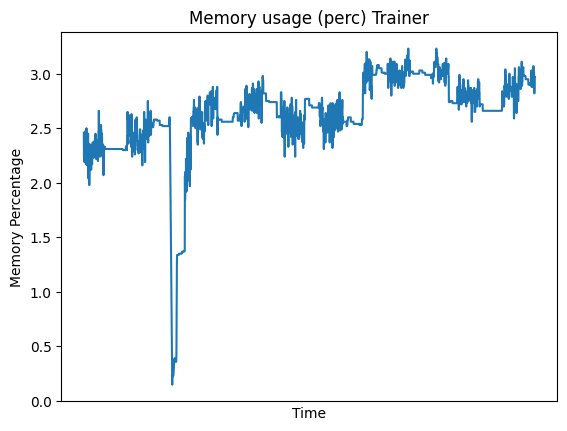

<Figure size 640x480 with 0 Axes>

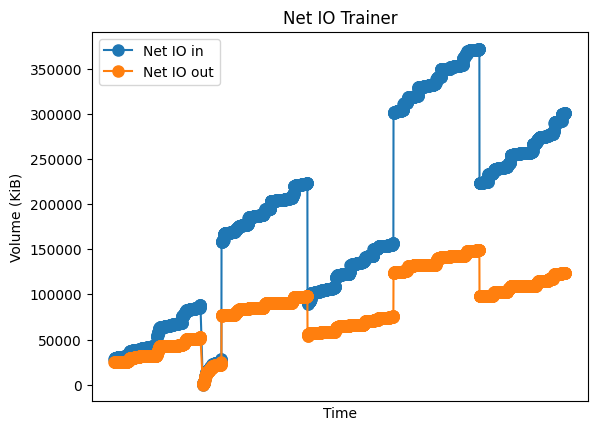

<Figure size 640x480 with 0 Axes>

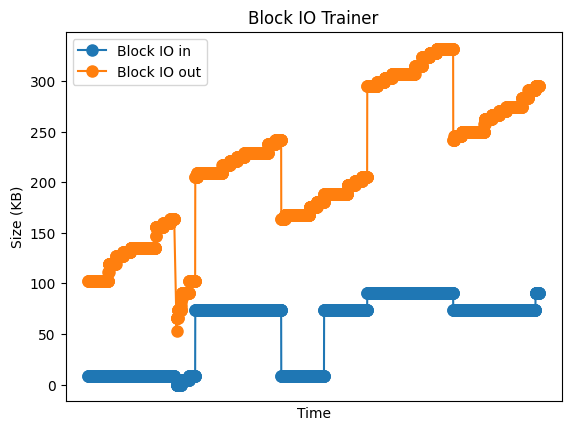

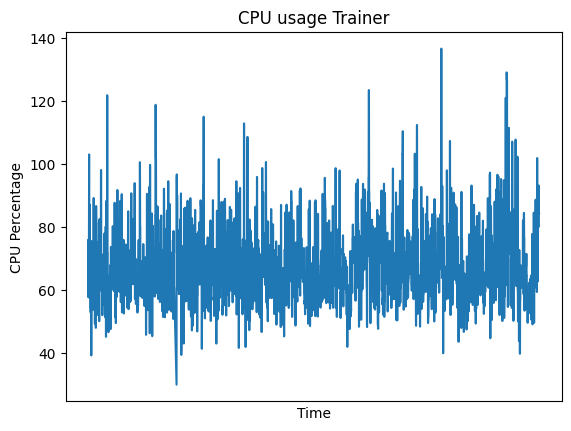

<Figure size 640x480 with 0 Axes>

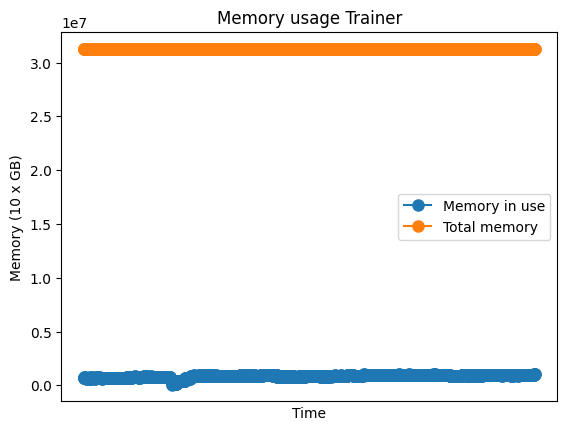

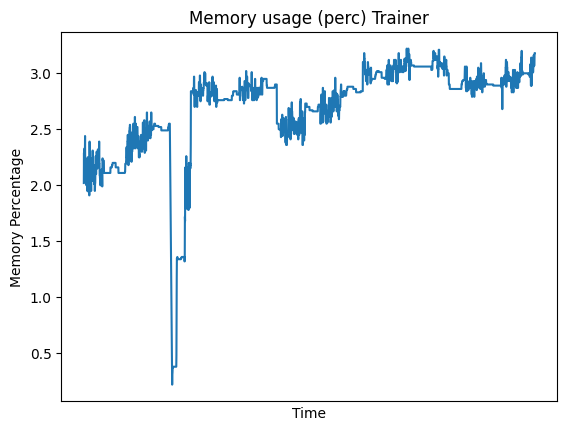

<Figure size 640x480 with 0 Axes>

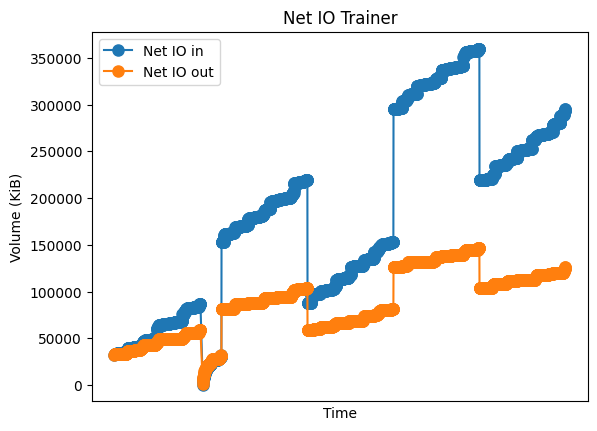

<Figure size 640x480 with 0 Axes>

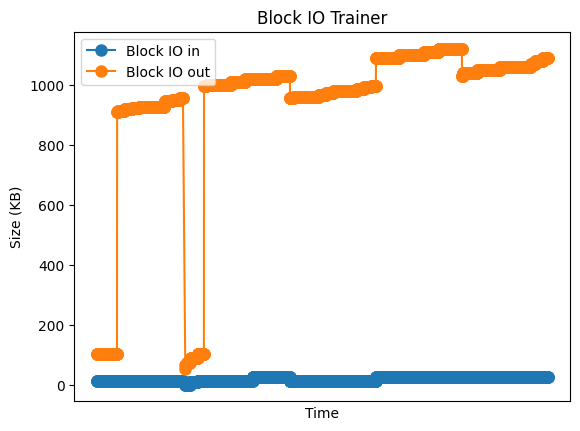

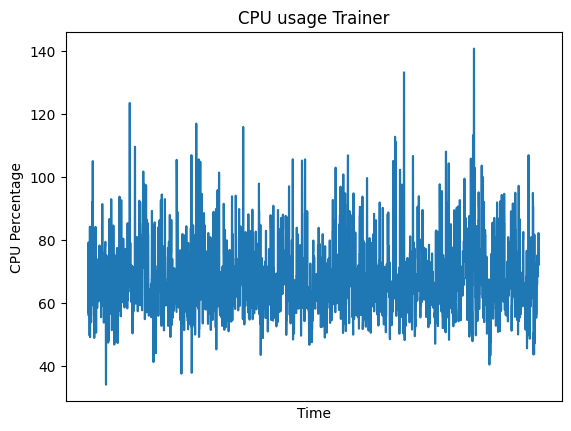

<Figure size 640x480 with 0 Axes>

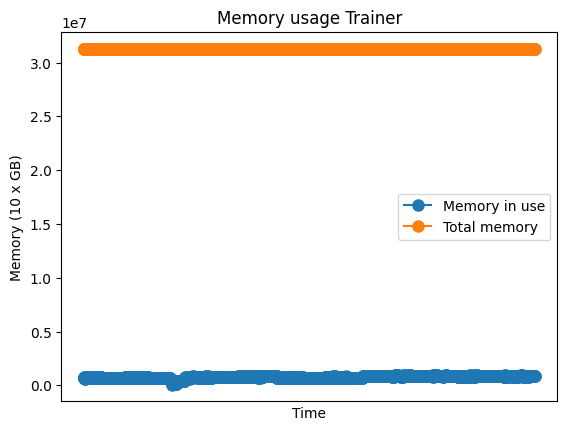

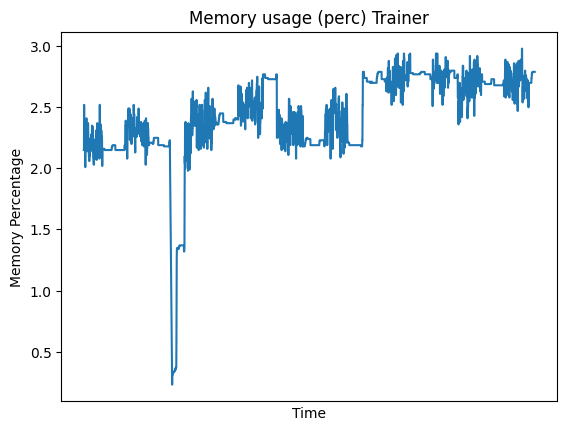

<Figure size 640x480 with 0 Axes>

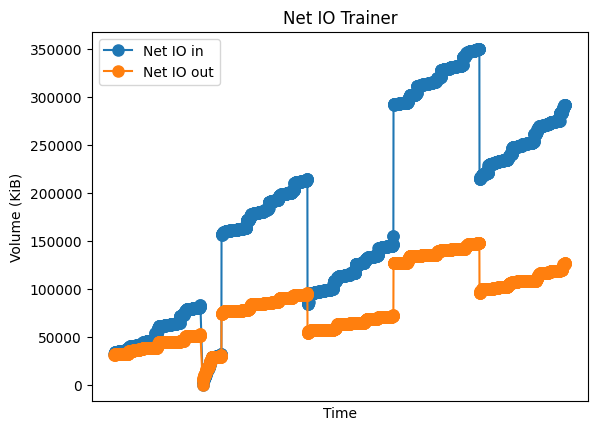

<Figure size 640x480 with 0 Axes>

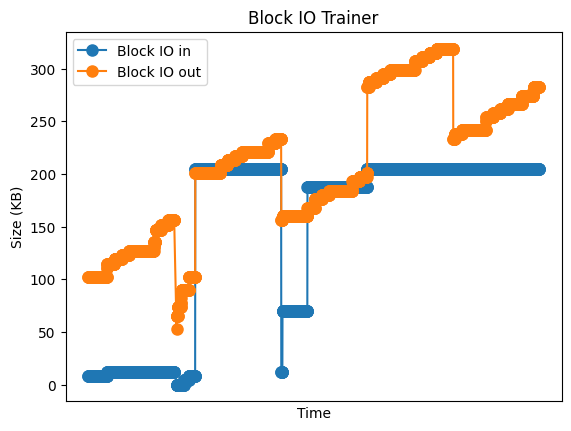

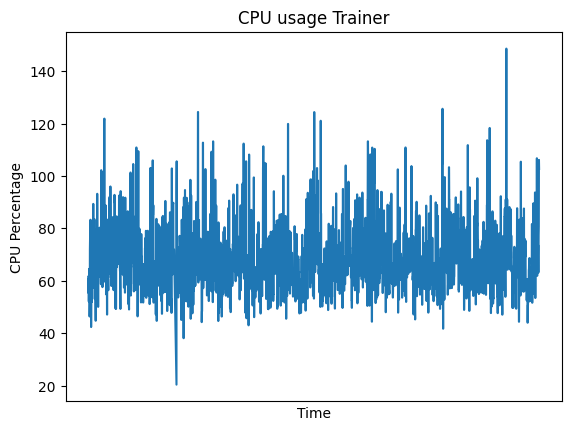

<Figure size 640x480 with 0 Axes>

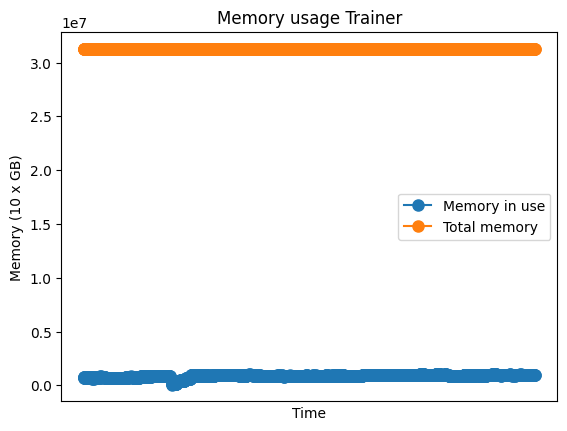

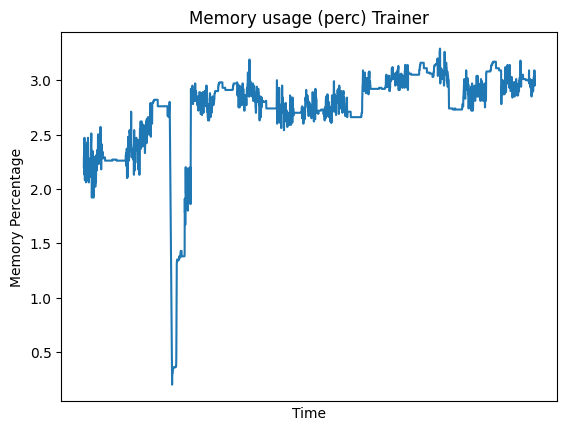

<Figure size 640x480 with 0 Axes>

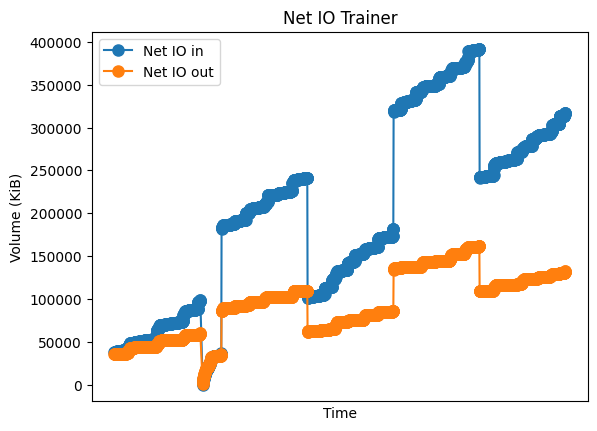

<Figure size 640x480 with 0 Axes>

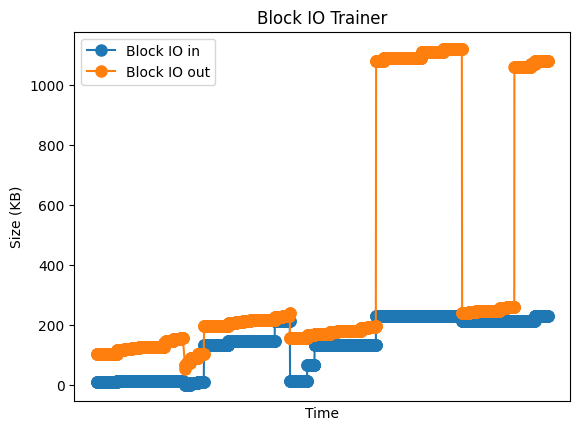

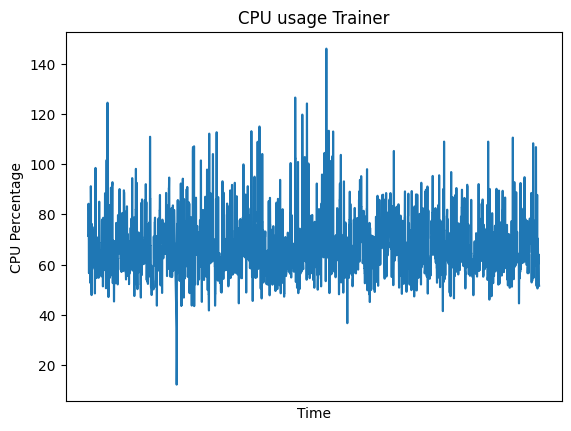

<Figure size 640x480 with 0 Axes>

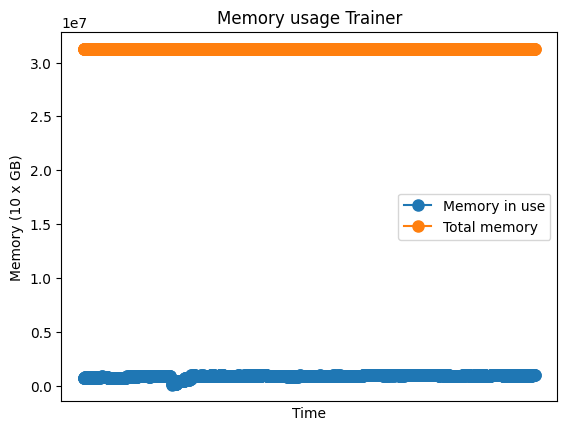

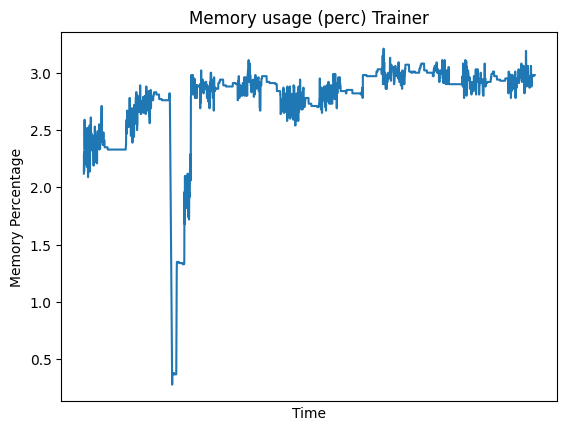

<Figure size 640x480 with 0 Axes>

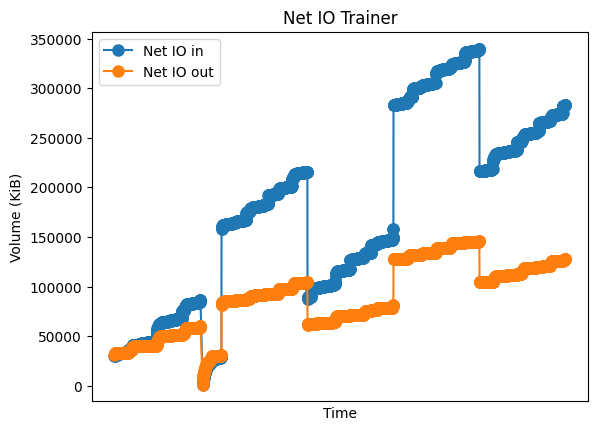

<Figure size 640x480 with 0 Axes>

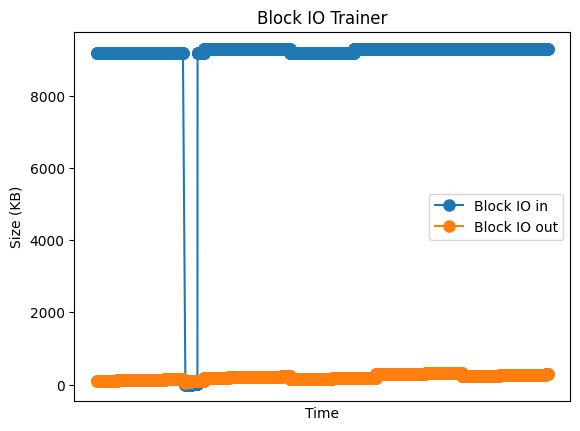

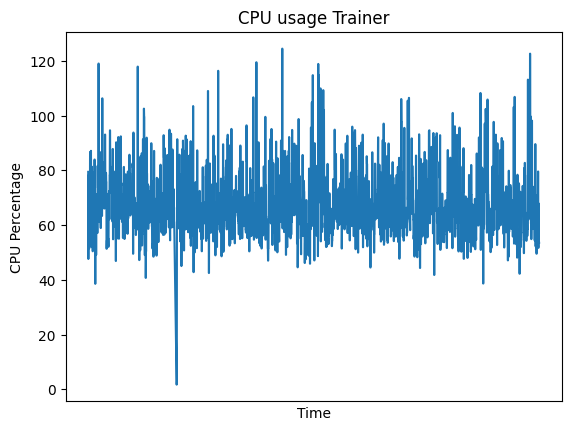

<Figure size 640x480 with 0 Axes>

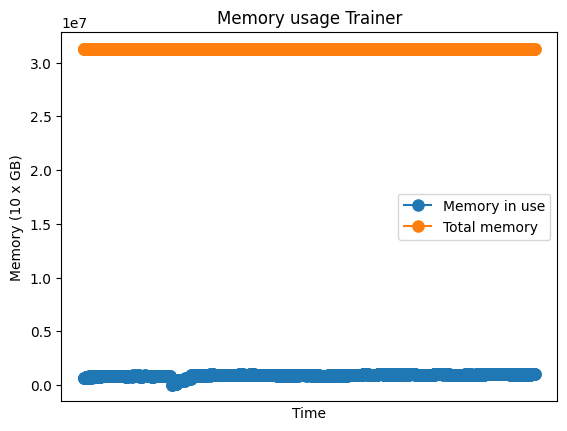

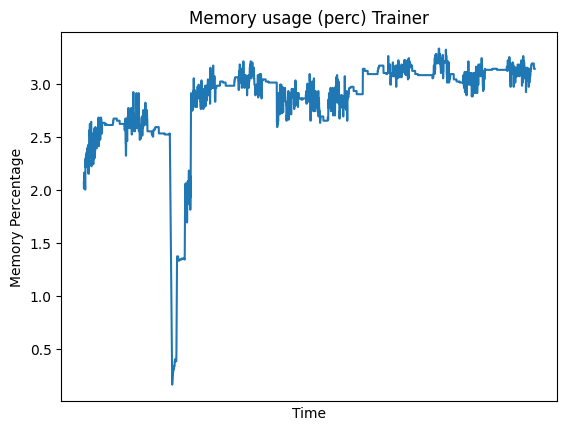

<Figure size 640x480 with 0 Axes>

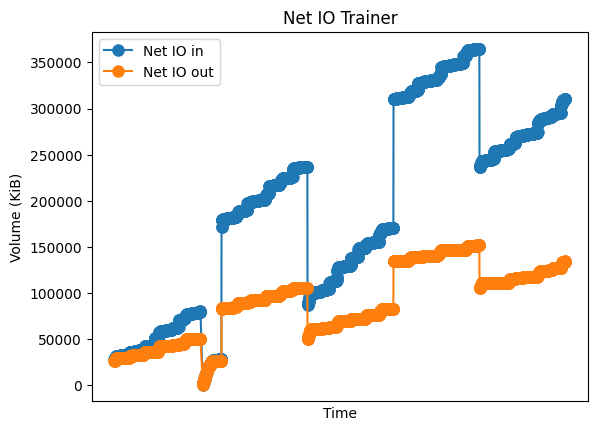

<Figure size 640x480 with 0 Axes>

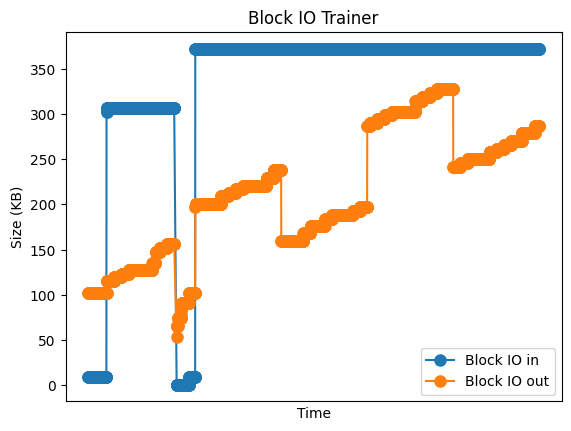

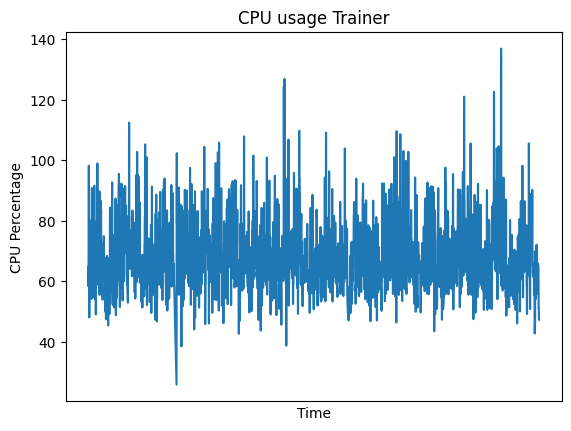

<Figure size 640x480 with 0 Axes>

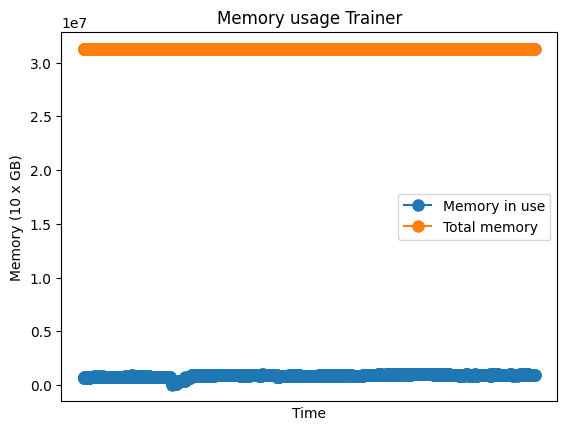

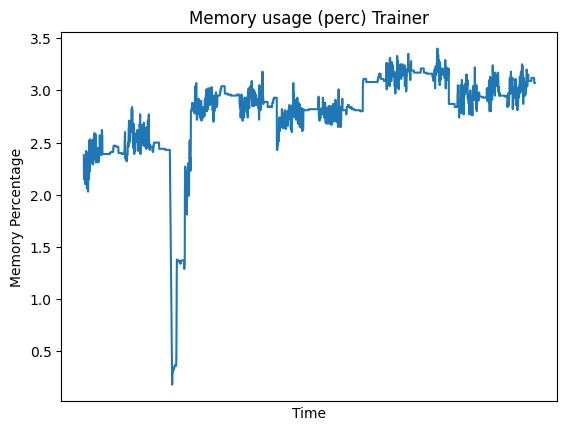

<Figure size 640x480 with 0 Axes>

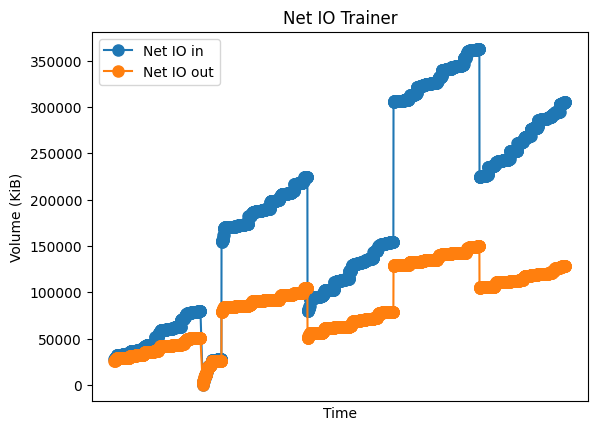

<Figure size 640x480 with 0 Axes>

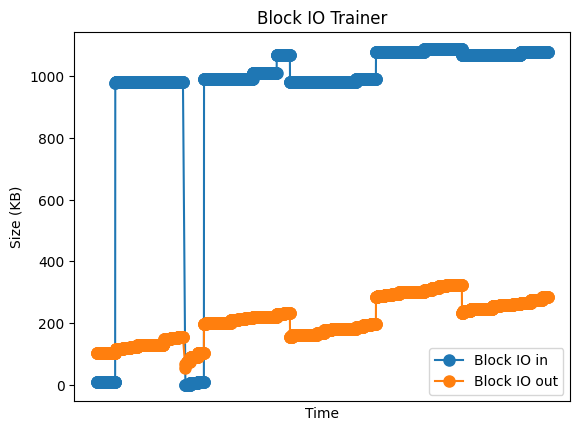

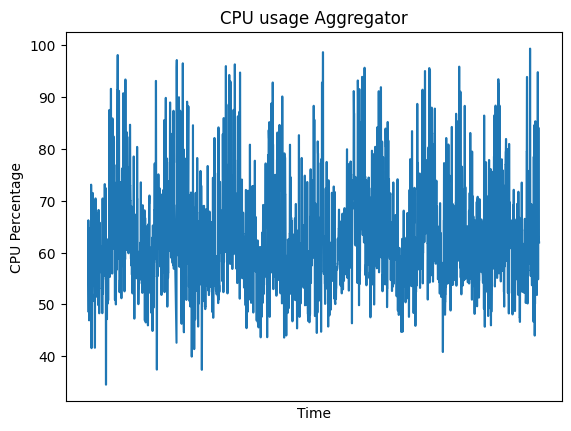

<Figure size 640x480 with 0 Axes>

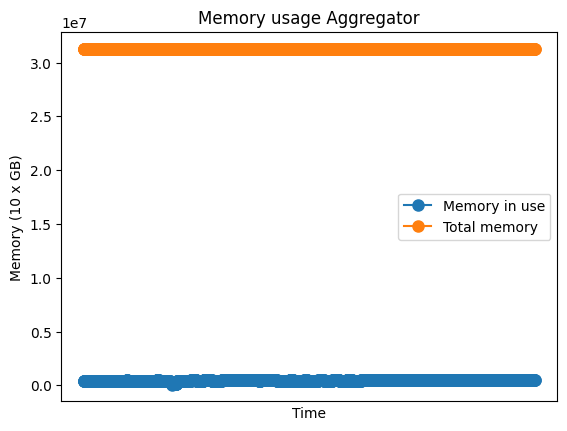

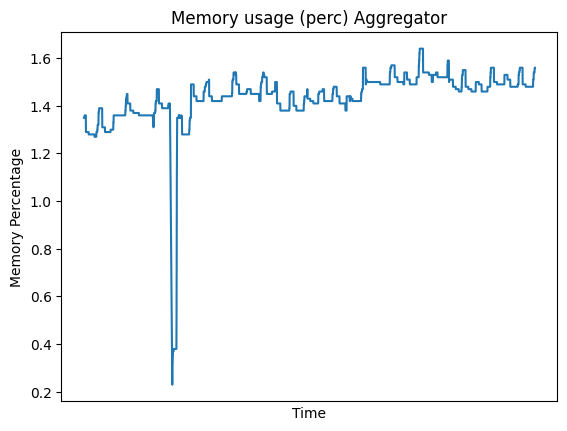

<Figure size 640x480 with 0 Axes>

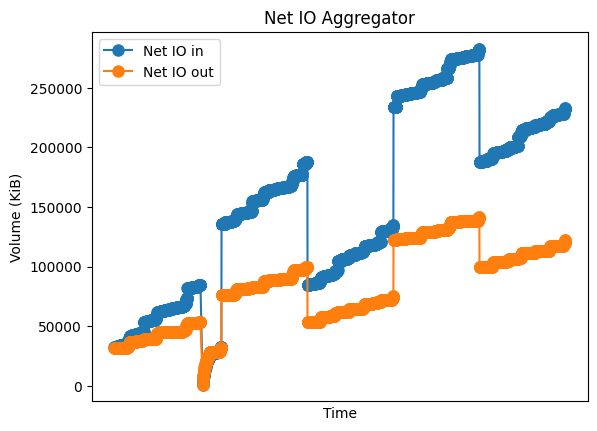

<Figure size 640x480 with 0 Axes>

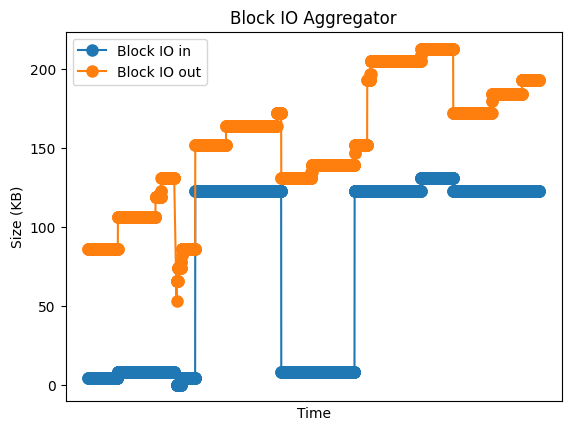

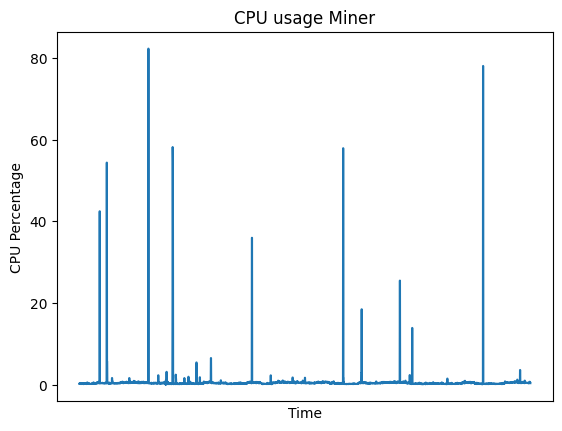

<Figure size 640x480 with 0 Axes>

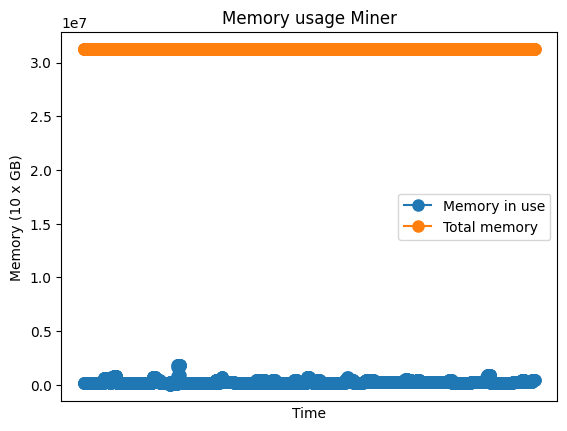

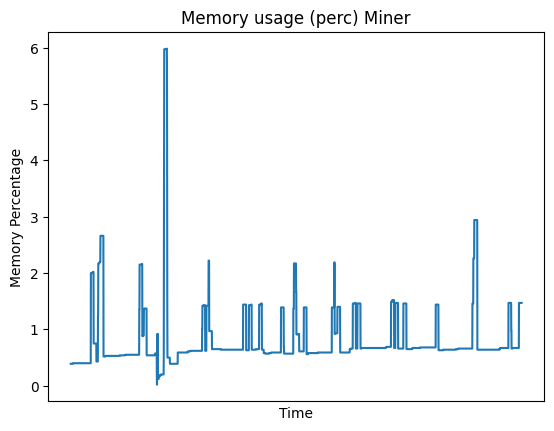

<Figure size 640x480 with 0 Axes>

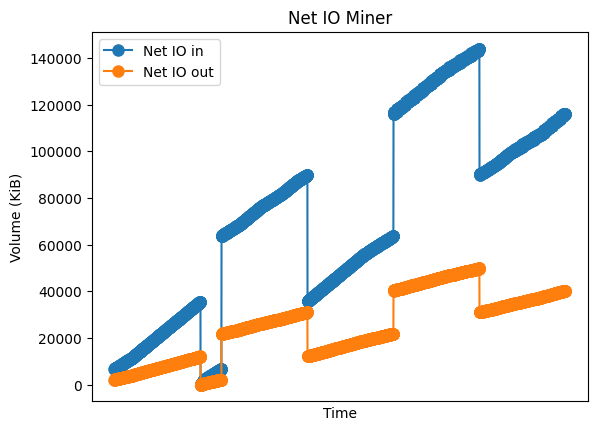

<Figure size 640x480 with 0 Axes>

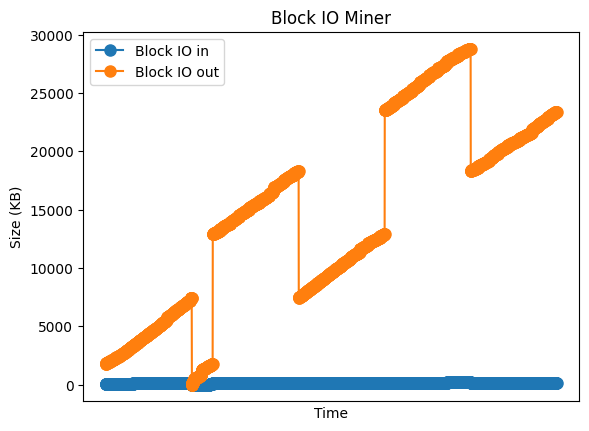

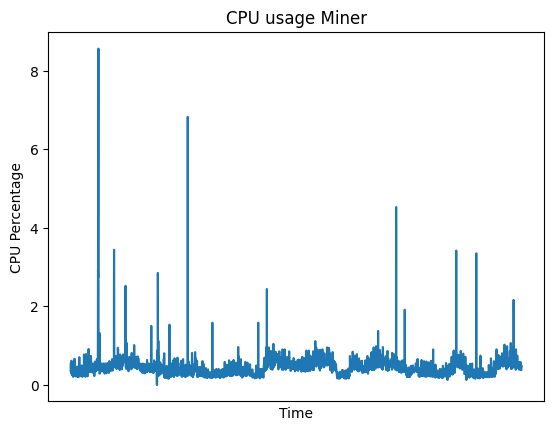

<Figure size 640x480 with 0 Axes>

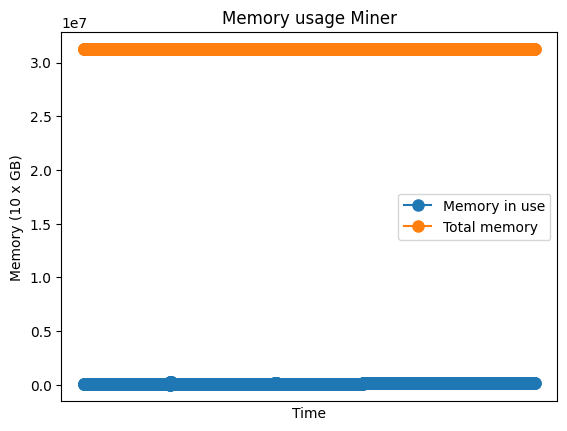

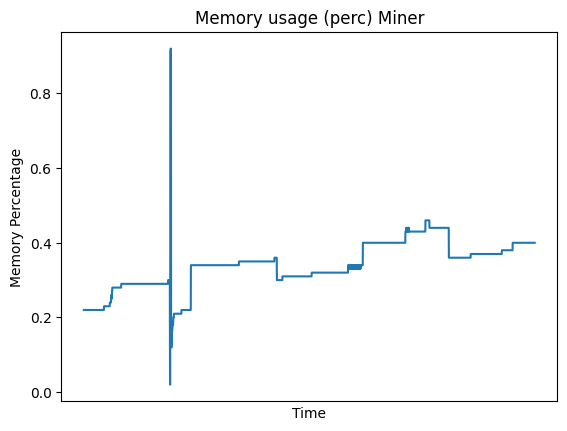

<Figure size 640x480 with 0 Axes>

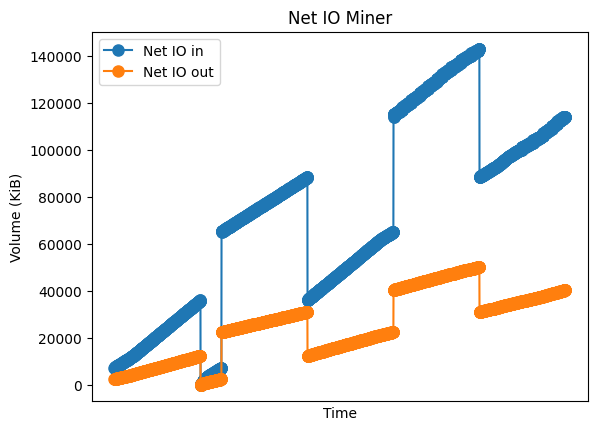

<Figure size 640x480 with 0 Axes>

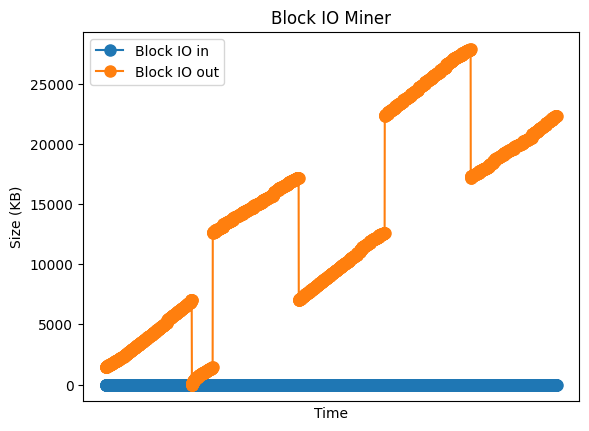

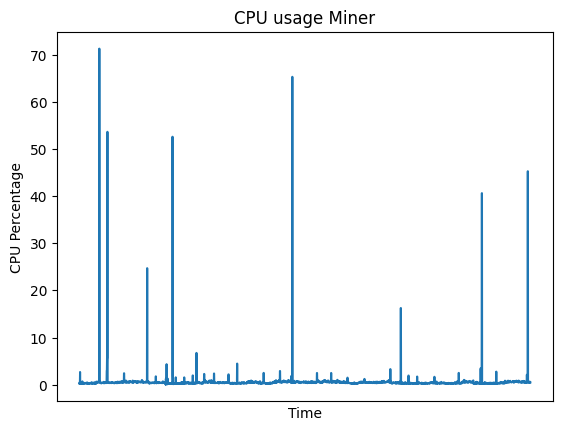

<Figure size 640x480 with 0 Axes>

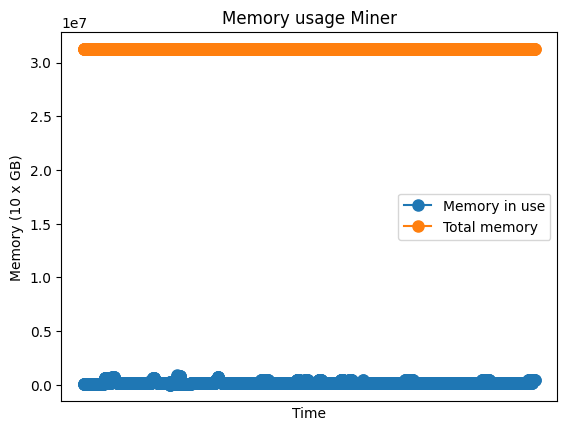

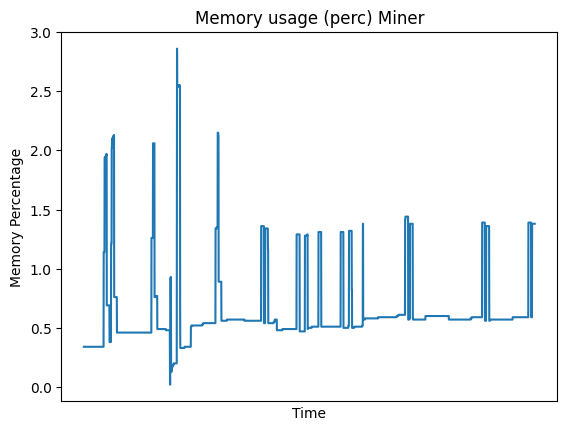

<Figure size 640x480 with 0 Axes>

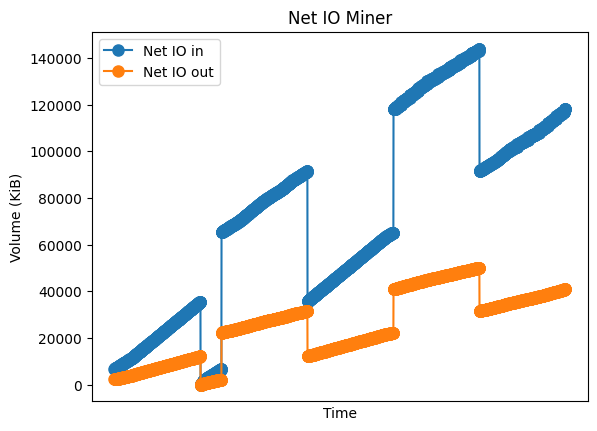

<Figure size 640x480 with 0 Axes>

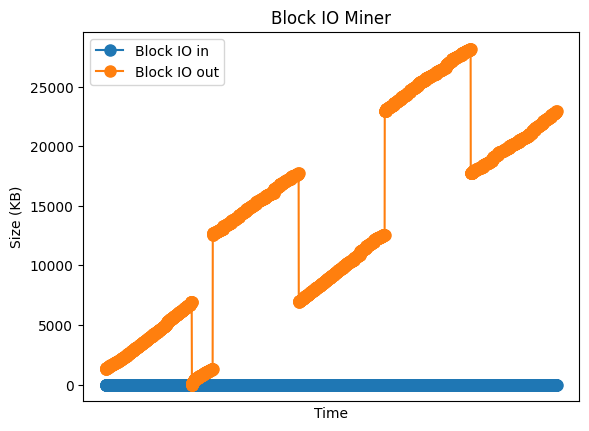

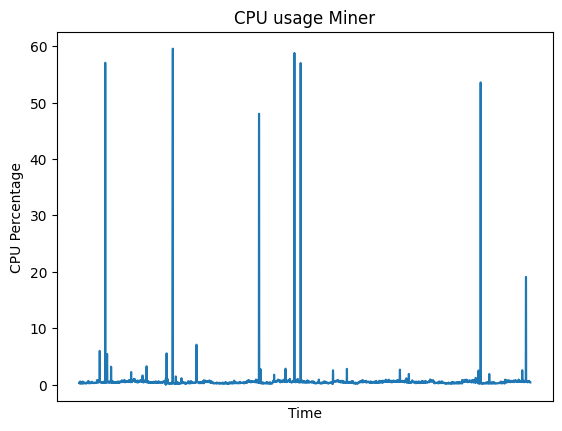

<Figure size 640x480 with 0 Axes>

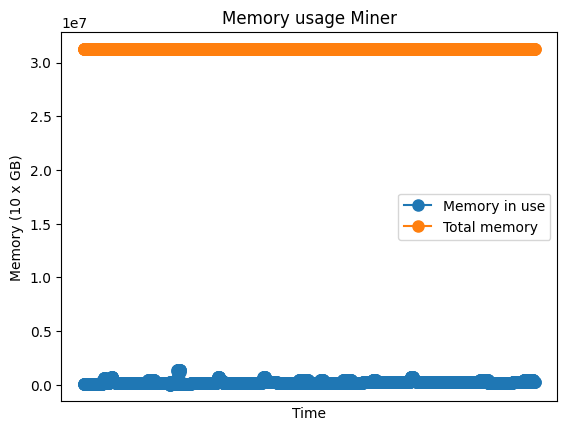

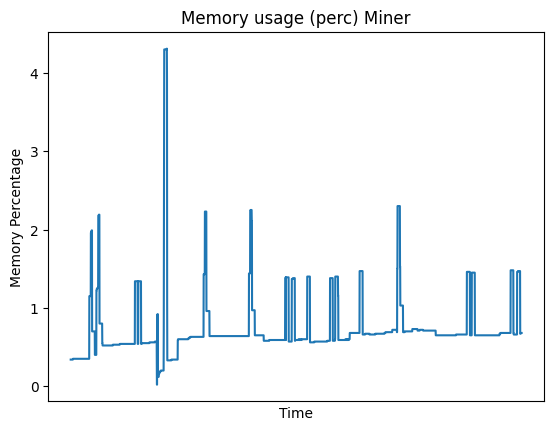

<Figure size 640x480 with 0 Axes>

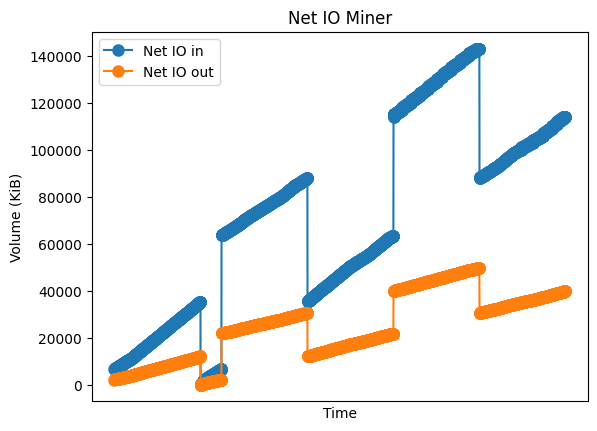

<Figure size 640x480 with 0 Axes>

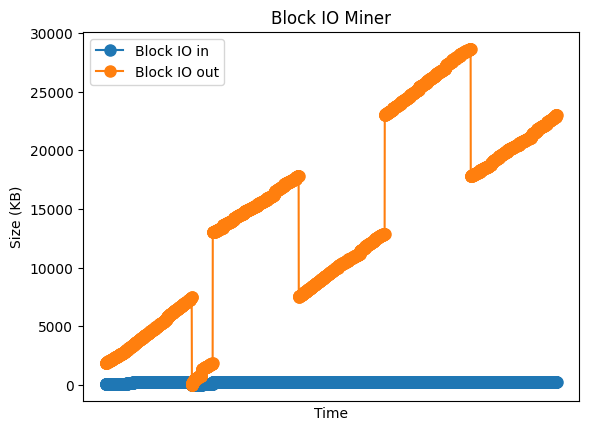

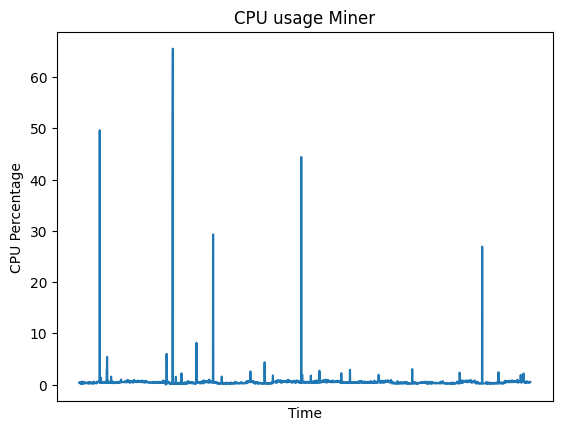

<Figure size 640x480 with 0 Axes>

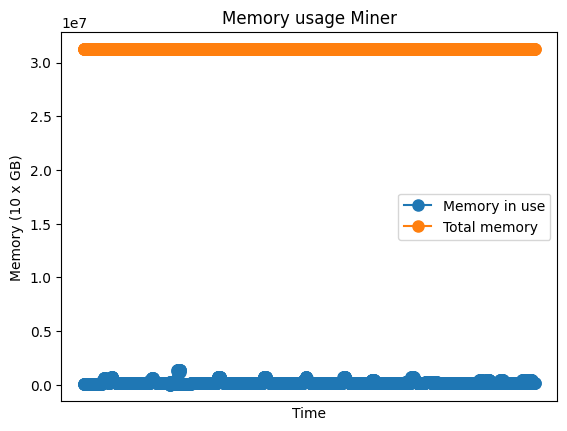

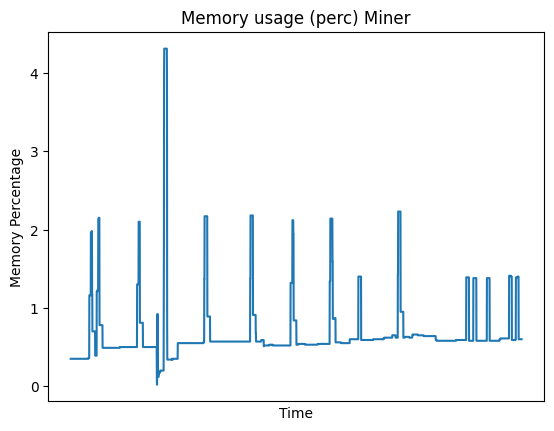

<Figure size 640x480 with 0 Axes>

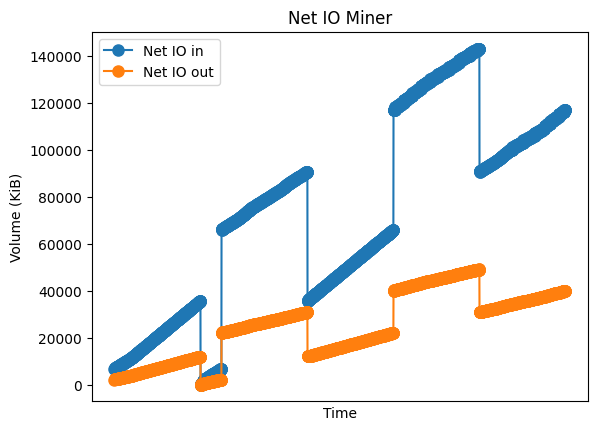

<Figure size 640x480 with 0 Axes>

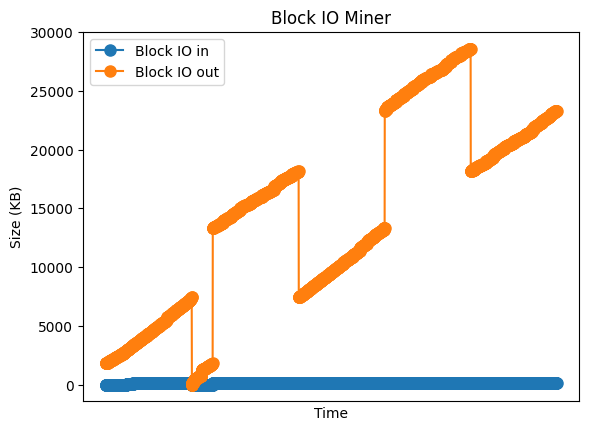

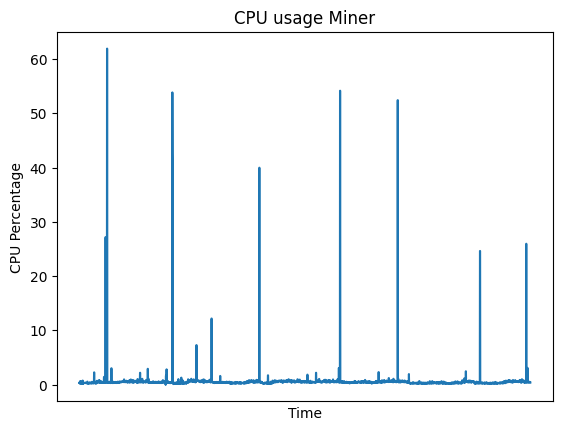

<Figure size 640x480 with 0 Axes>

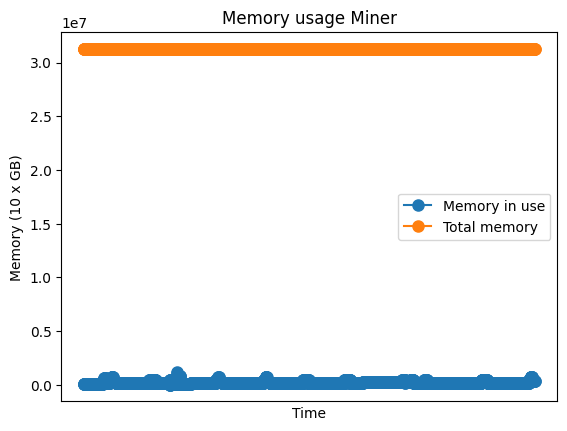

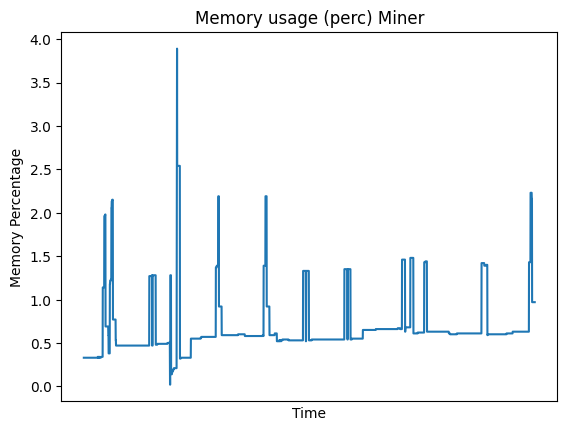

<Figure size 640x480 with 0 Axes>

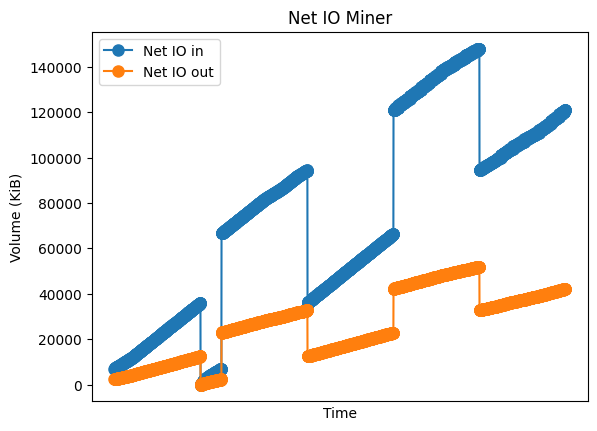

<Figure size 640x480 with 0 Axes>

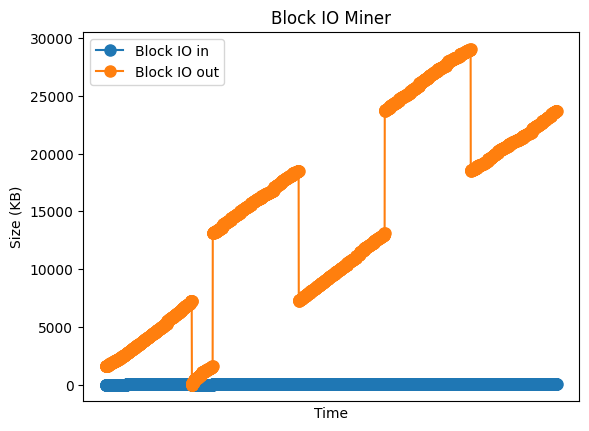

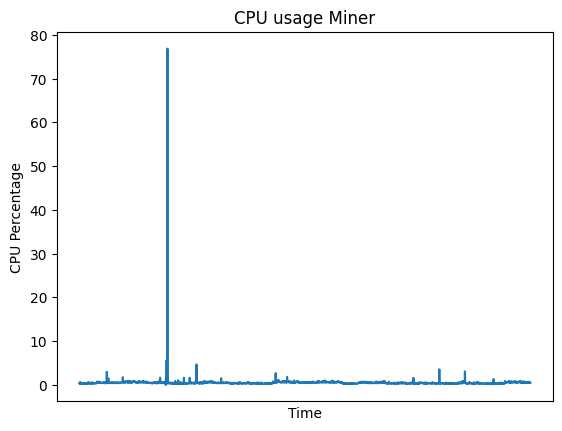

<Figure size 640x480 with 0 Axes>

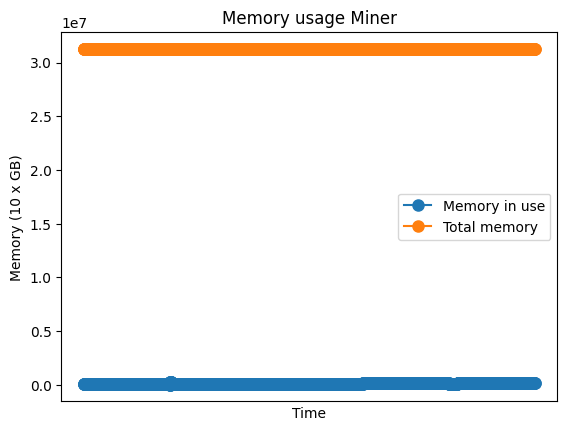

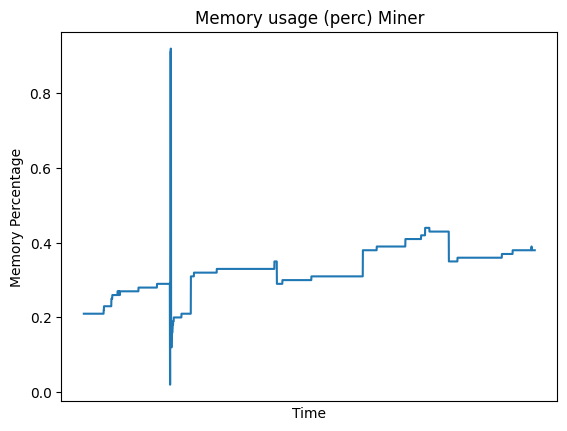

<Figure size 640x480 with 0 Axes>

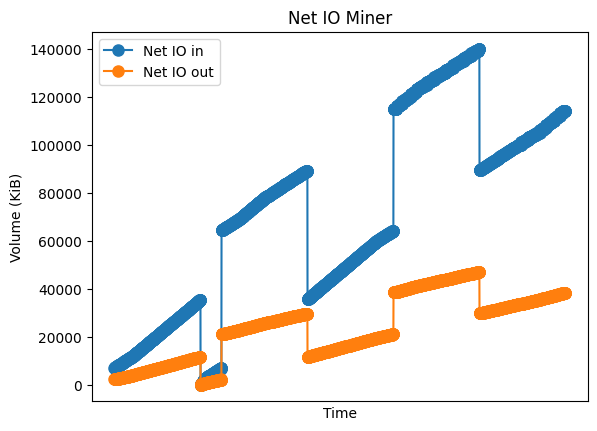

<Figure size 640x480 with 0 Axes>

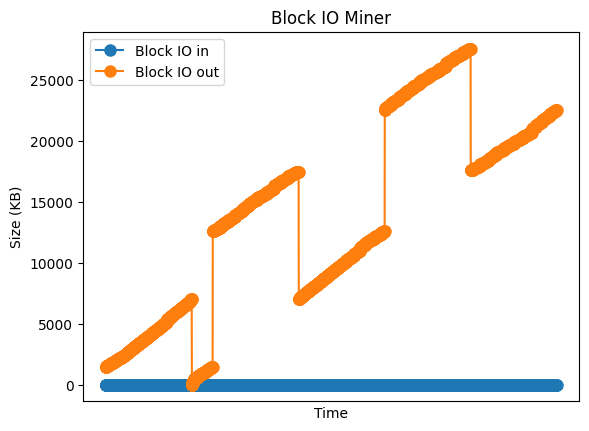

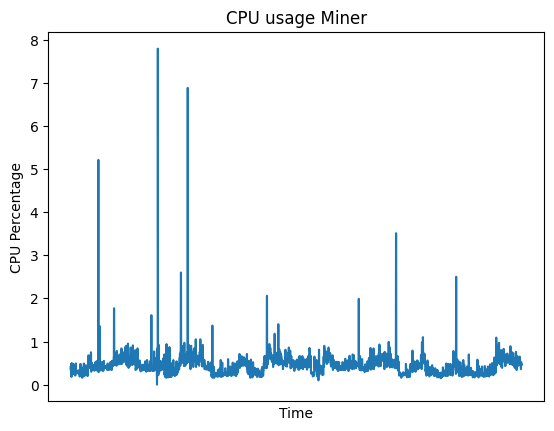

<Figure size 640x480 with 0 Axes>

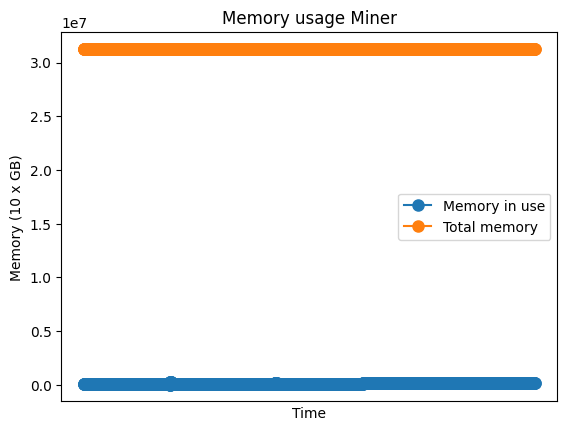

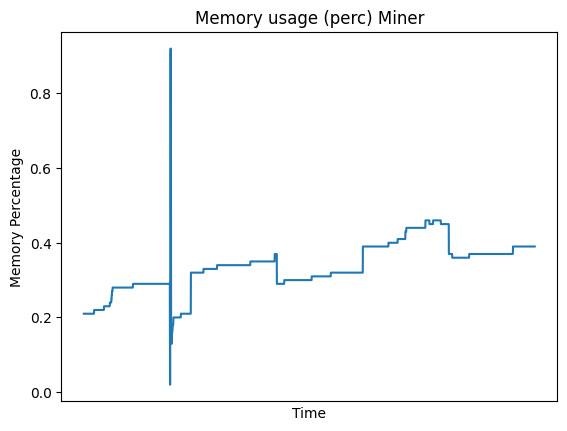

<Figure size 640x480 with 0 Axes>

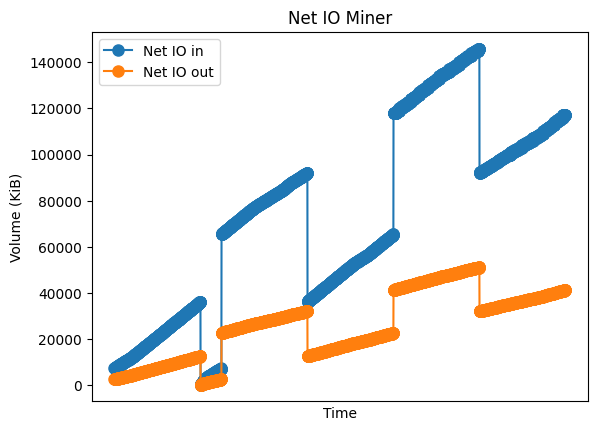

<Figure size 640x480 with 0 Axes>

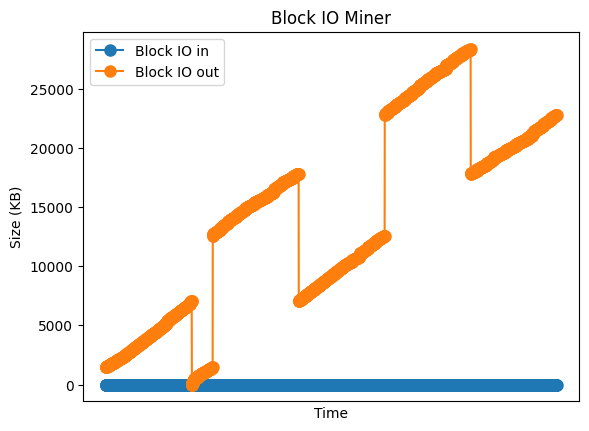

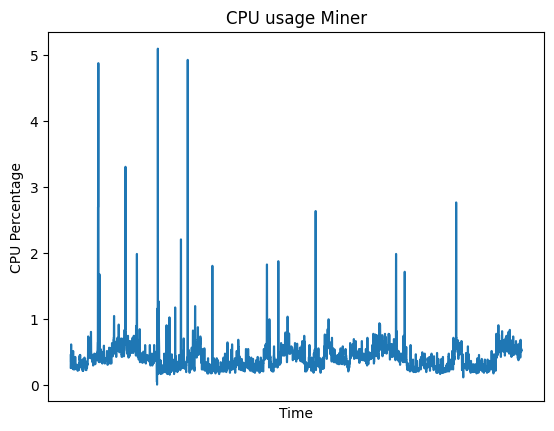

<Figure size 640x480 with 0 Axes>

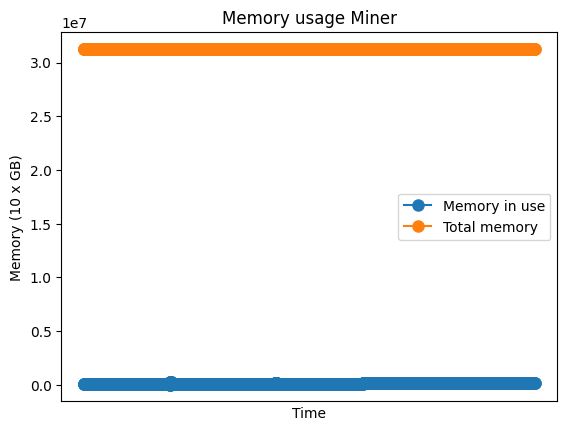

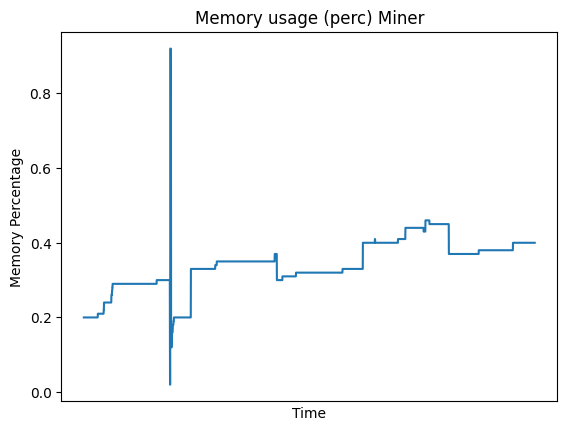

<Figure size 640x480 with 0 Axes>

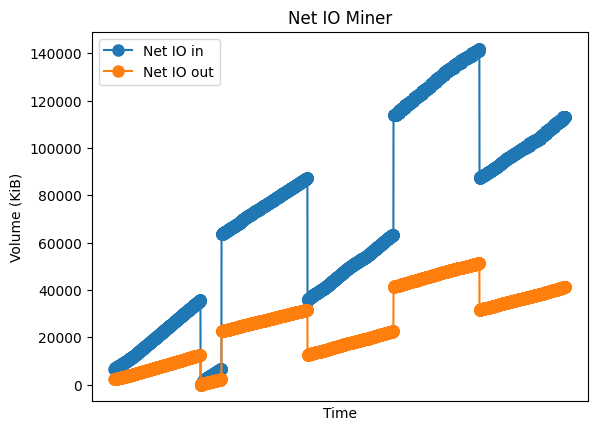

<Figure size 640x480 with 0 Axes>

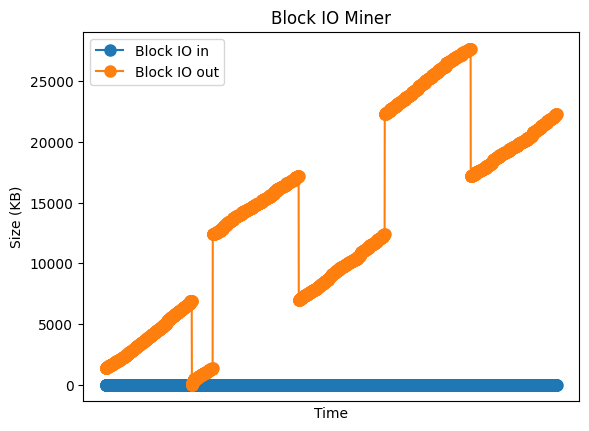

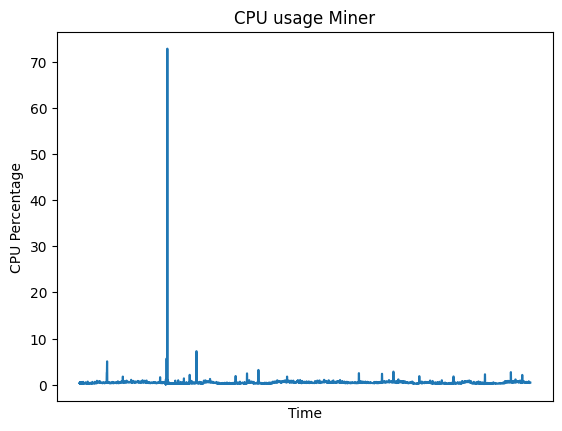

<Figure size 640x480 with 0 Axes>

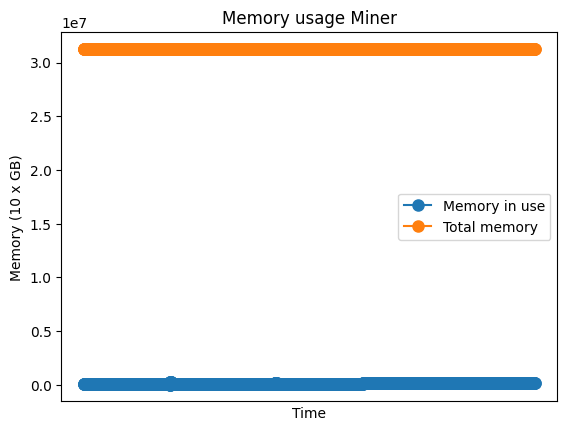

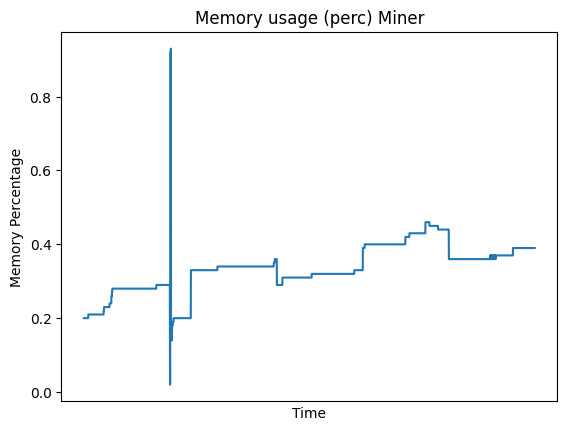

<Figure size 640x480 with 0 Axes>

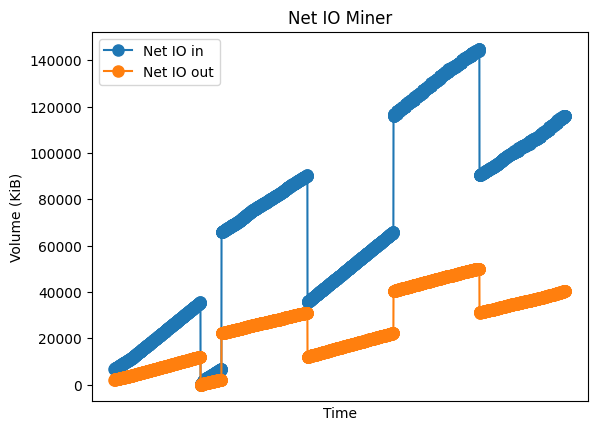

<Figure size 640x480 with 0 Axes>

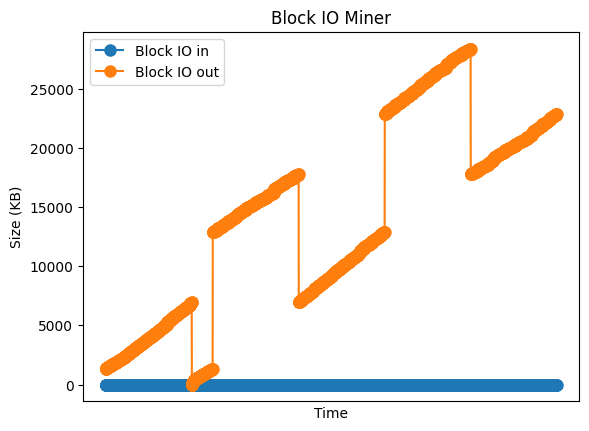

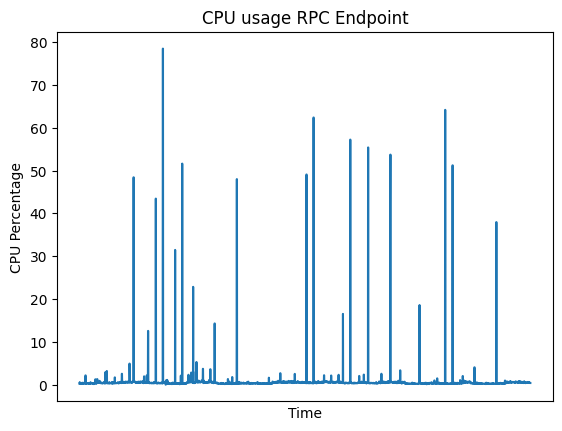

<Figure size 640x480 with 0 Axes>

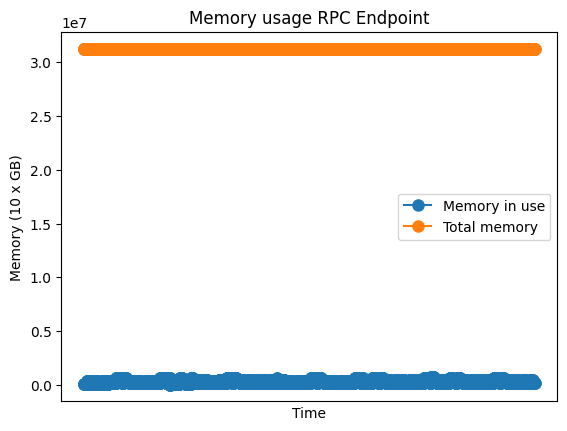

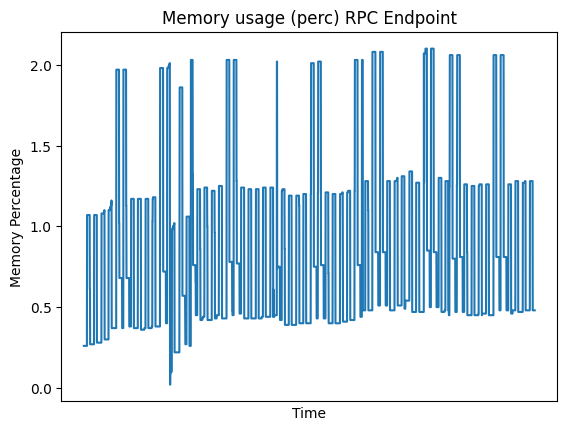

<Figure size 640x480 with 0 Axes>

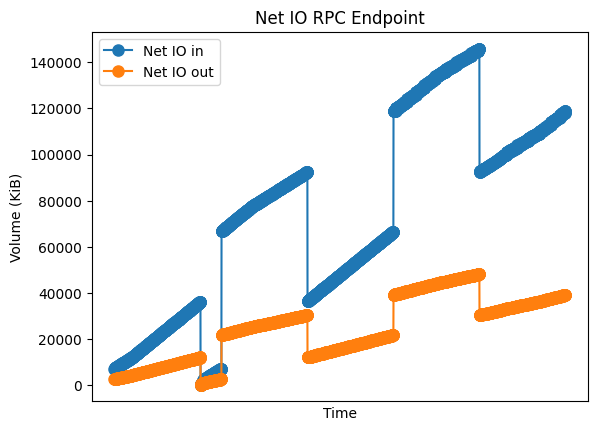

<Figure size 640x480 with 0 Axes>

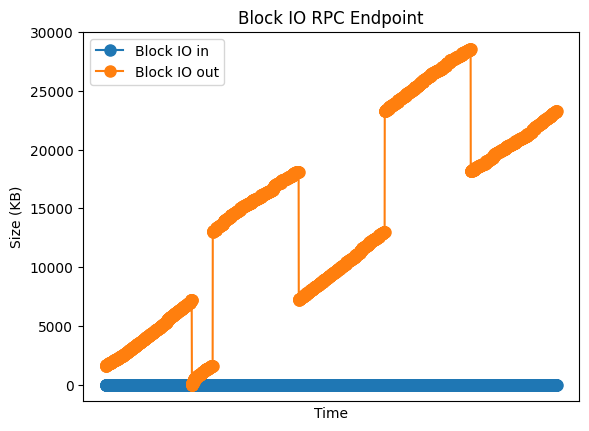

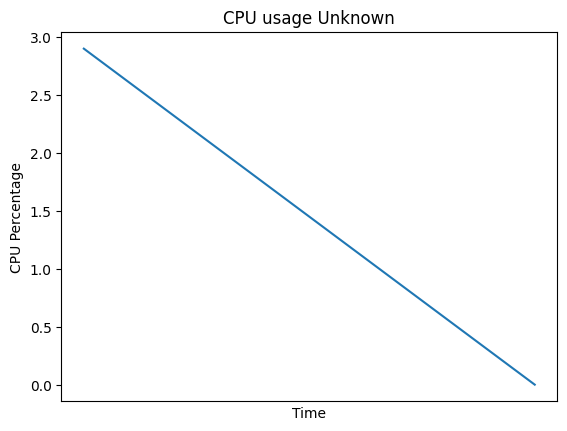

<Figure size 640x480 with 0 Axes>

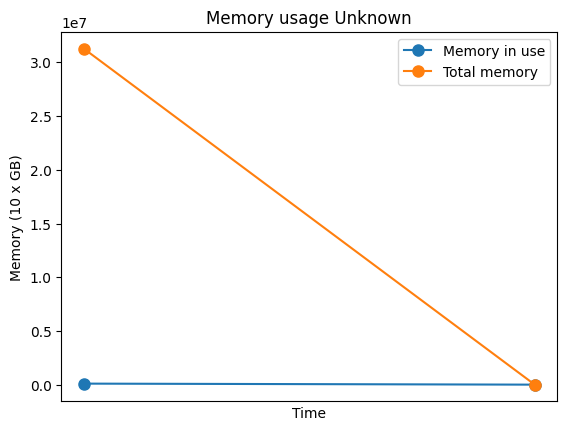

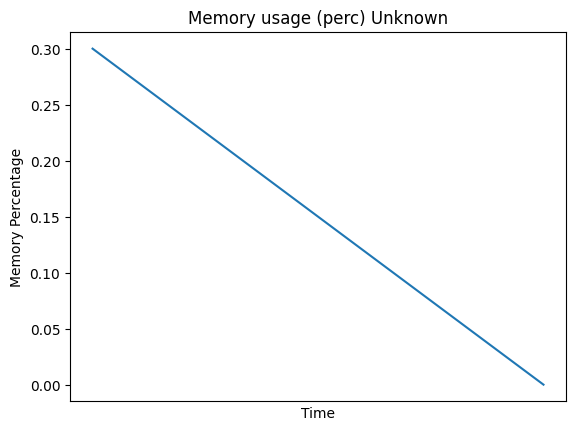

<Figure size 640x480 with 0 Axes>

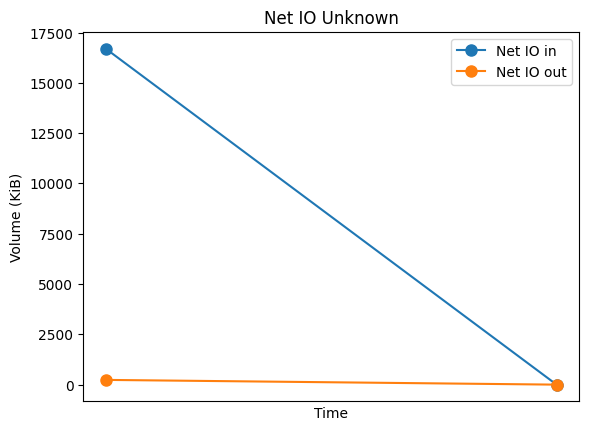

<Figure size 640x480 with 0 Axes>

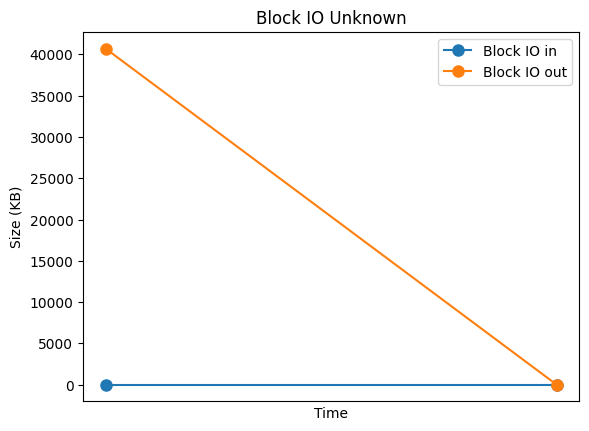

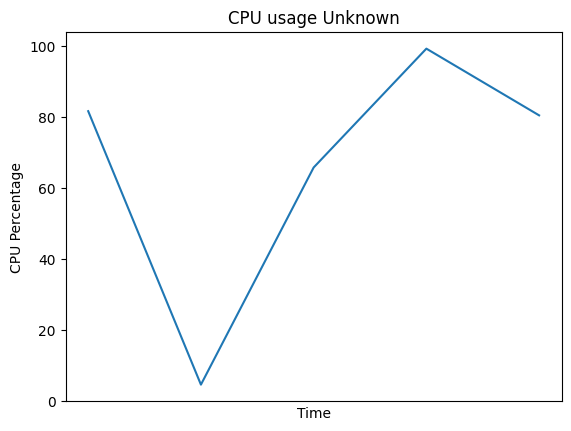

<Figure size 640x480 with 0 Axes>

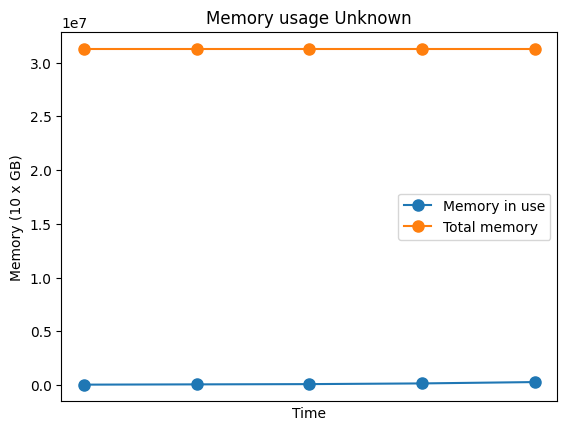

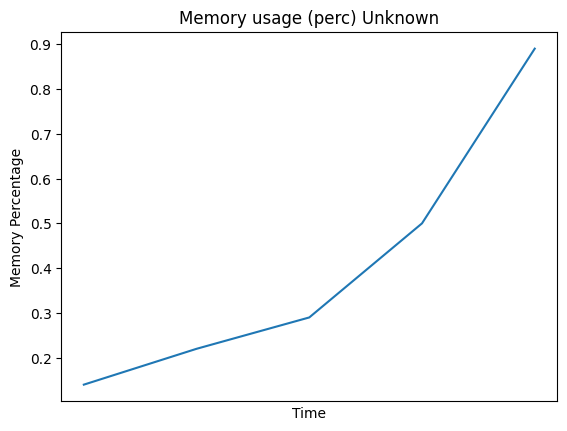

<Figure size 640x480 with 0 Axes>

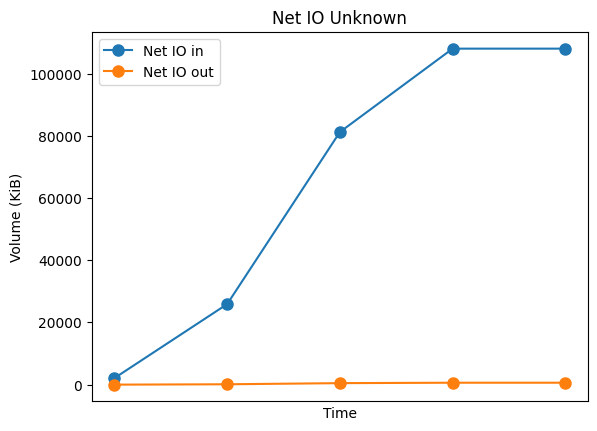

<Figure size 640x480 with 0 Axes>

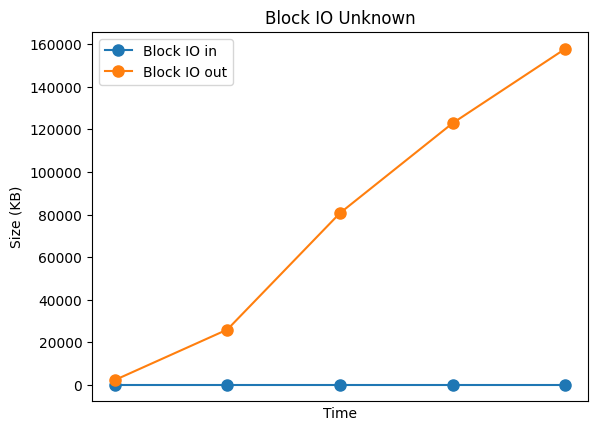

In [18]:

for name in names:
    do_cpu(name, df)
    do_mem(name, df)
    do_mem_perc(name, df)
    do_io(name, df)
    do_block_io(name, df)